In [188]:
import numpy as np
import pandas as pd
import random
from scipy.stats import zscore
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'patients_analysis/output_files_patients/'

from scripts.io_library import MyLib
from scripts.visualization import MyVisualization
from scripts.utils import Utils
from scripts.invoking_R_functions import MyRFunctions

In [189]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
R3_features_file = 'Figure5/output_fig5/R3_features_Up.csv'
R3_features = pd.read_csv(R3_features_file)['feature'].tolist()
print(len(R3_features))

50


In [191]:
R4_features_file = 'Figure5/output_fig5/R4_features_Up.csv'
R4_features = pd.read_csv(R4_features_file)['feature'].tolist()
print(len(R4_features))

50


In [192]:
# MT_color = '#2C4E78'
# WT_color = '#CED5E0'
control_color = '#c9c7c7'
R3_color = MyVisualization.feat_colors_dic['RNA_Cluster']['R3']
R4_color = MyVisualization.feat_colors_dic['RNA_Cluster']['R4']
color_dic = {'R3': R3_color, 'R3 & R4':'#A00000', 'R4': R4_color, 'WT': '#d4d4d4'}#'#ffa600'

# ICGC
Nakamura, Hiromi, et al. "Genomic spectra of biliary tract cancer." Nature genetics 47.9 (2015): 1003-1010.
https://platform.icgc-argo.org/

In [193]:
ICGC_file =  'Patients_Data/ICGC/ICGC_dataset.xlsx'
data_df = MyLib.load_xls(ICGC_file, sheet_no=0)
ICGC_info_df = data_df.loc[:10, :].T
ICGC_info_df.columns = ICGC_info_df.iloc[0] 
ICGC_info_df = ICGC_info_df[1:]
ICGC_info_df.head()

Gene_ID,Donor_sex,Age_at_diagnosis,donor_tumour_stage_at_diagnosis,Histological_type,IDH_status,NaN,FGFR2_mut,Relapse_event,Relapse_interval,OS_event,donor_survival_time
BD101,male,68,3,ICC,NaN,NaN,NaN,1,100,1,1829
BD104,male,66,4A,ICC,NaN,NaN,NaN,1,105,1,168
BD105,female,58,2,ICC,NaN,NaN,NaN,1,923,0,1981
BD109,male,81,2,ICC,NaN,NaN,NaN,0,380,0,380
BD10,male,72,4A,ICC,NaN,NaN,NaN,1,449,1,1153


In [194]:
exp_df = data_df.loc[39:, :] # RPKM normalized transcripts
exp_df.set_index('Gene_ID', drop=True, inplace=True)
exp_df = exp_df.T.astype(float)
exp_df = exp_df.dropna(axis=1)
exp_df.shape

(182, 26740)

In [195]:
mut_file = 'Patients_Data/ICGC/ICGC_Mutations.xlsx'
raw_mut_df = MyLib.load_xls(mut_file, sheet_no=0, index_col=0)
print('Shape:', raw_mut_df.shape)
raw_mut_df = raw_mut_df[~raw_mut_df.index.duplicated(keep='first')]
print('Shape:', raw_mut_df.shape)
raw_mut_df.index = raw_mut_df.index.map(lambda x: x.replace('T',''))
raw_mut_df['KRAS'] = raw_mut_df['KRAS BRAF NRAS'].apply(lambda x:x if x=='KRAS' else np.nan)
raw_mut_df['BRAF'] = raw_mut_df['KRAS BRAF NRAS'].apply(lambda x:x if x=='BRAF' else np.nan)
raw_mut_df.columns


Shape: (234, 28)
Shape: (233, 28)


Index(['Tumor type 2', 'WES (Y=done, N-not done)',
       'RNAseq(Y=done, N-not done)', 'Gender', 'Virus', 'HBV integration',
       'PSC', 'Histology', 'overall survival (days)', 'T', 'N', 'M', 'Stage',
       'Field1', 'IDH', 'BAP1', 'ARID1A', 'ARID1B', 'ARID2', 'PBRM1', 'FGFR2',
       'FGFR2.1', 'SMAD4', 'KRAS BRAF NRAS', 'KRAS BRAF NRAS.1', 'TP53',
       'CDKN2A', 'PIK3CA', 'KRAS', 'BRAF'],
      dtype='object')

In [196]:
raw_mut_df.head()

,Tumor type 2,"WES (Y=done, N-not done)","RNAseq(Y=done, N-not done)",Gender,Virus,HBV integration,PSC,Histology,overall survival (days),T,...,FGFR2,FGFR2.1,SMAD4,KRAS BRAF NRAS,KRAS BRAF NRAS.1,TP53,CDKN2A,PIK3CA,KRAS,BRAF
submitted_sample_id,,,,,,,,,,,,,,,,,,,,,
BD117,IHCC,Y,Y,M,NBNC,N,N,M/D,894.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BD149,IHCC,Y,Y,M,NBNC,N,N,M/D,403.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BD219,IHCC,Y,Y,F,HBV,N,N,M/D,1281.0,2a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BD81,IHCC,Y,Y,M,NBNC,N,N,M/D,1905.0,2a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BD141,IHCC,Y,Y,M,NBNC,N,N,M/D,1756.0,2a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
mutations = ['IDH', 'BAP1', 'PBRM1', 'ARID1A', 'KRAS', 'BRAF', 'SMAD4', 'FGFR2.1'] # Select the fusion column FGFR2.1
icgc_mut_df = pd.DataFrame(0, index=exp_df.index, columns=mutations)
ids = list(set(raw_mut_df.index.values).intersection(exp_df.index.values))
icgc_mut_df.loc[ids, mutations] = raw_mut_df.loc[ids, mutations]
icgc_mut_df = icgc_mut_df.rename(columns={'FGFR2.1':'FGFR2_MT', 'IDH':'IDH_MT', 'BAP1':'BAP1_MT', 'PBRM1':'PBRM1_MT', 'ARID1A':'ARID1A_MT', 'KRAS':'KRAS_MT', 'BRAF':'BRAF_MT', 'SMAD4':'SMAD4_MT'})
icgc_mut_df = icgc_mut_df.fillna(0)
icgc_mut_df[icgc_mut_df != 0] = 1

In [198]:
muts_l = ['IDH_MT', 'BAP1_MT', 'FGFR2_MT']
icgc_mut_df['mutation_R3'] = (icgc_mut_df['IDH_MT'] | icgc_mut_df['BAP1_MT'] | icgc_mut_df['FGFR2_MT']).astype(int)
icgc_mut_df['mutation_R3'] = icgc_mut_df['mutation_R3'].replace({0: 'WT', 1: 'MT'})

R4_muts_l = ['KRAS_MT', 'BRAF_MT', 'SMAD4_MT']
icgc_mut_df['mutation_R4'] = (icgc_mut_df['KRAS_MT'] | icgc_mut_df['BRAF_MT'] | icgc_mut_df['SMAD4_MT']).astype(int)
icgc_mut_df['mutation_R4'] = icgc_mut_df['mutation_R4'].replace({0: 'WT', 1: 'MT'})
icgc_mut_df.shape

(182, 10)

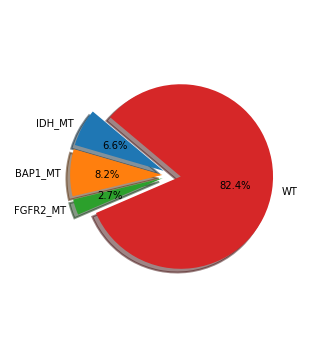

In [199]:
Utils.piechart(icgc_mut_df[['IDH_MT', 'BAP1_MT', 'FGFR2_MT']])

## ssGSEA for R3 Signature

Apply ssGSEA on R3 features

In [200]:
cluster = 'R3'
R3_features_filtered = list(set(R3_features).intersection(exp_df.columns))
print('Shared features:', len(R3_features_filtered))

Shared features: 50


In [201]:
ssgsea_df = MyRFunctions.ssgsea(exp_df.T, R3_features_filtered)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [202]:
icgc_R3_ssgsea_df = zscore(ssgsea_df)
icgc_R3_ssgsea_df

,ssGSEA
BD101,1.215253
BD104,-0.031344
BD105,1.061743
BD109,1.001801
BD10,-0.264005
...,...
BD91,0.264046
BD92,1.102429
BD95,0.788191
BD97,0.169895


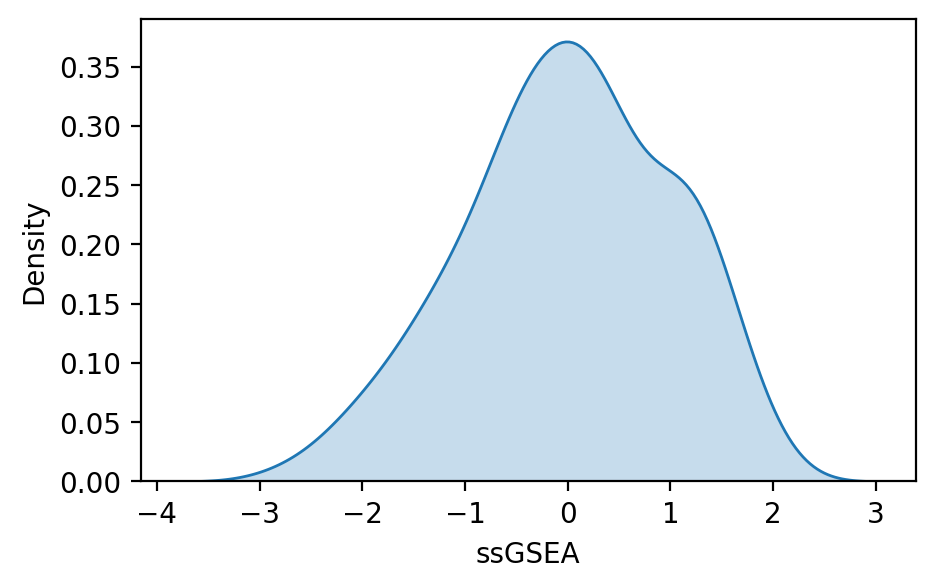

In [203]:
MyVisualization.plot_distribution(icgc_R3_ssgsea_df['ssGSEA'])

In [204]:
R3_threshold = np.percentile(icgc_R3_ssgsea_df['ssGSEA'], 75)
print('ssGSEA enrichment cut-off:', R3_threshold)
icgc_R3_ssgsea_df['High_ssGSEA'] = (icgc_R3_ssgsea_df['ssGSEA'] >= R3_threshold).astype(int)
ssgsea_dic = {0: 'Rest', 1: 'R3 Enriched'}
icgc_R3_ssgsea_df['High_ssGSEA'] = icgc_R3_ssgsea_df['High_ssGSEA'].replace(ssgsea_dic)

ssGSEA enrichment cut-off: 0.7903044270946068


In [205]:
df = pd.concat([icgc_R3_ssgsea_df, icgc_mut_df, exp_df], axis=1)
df = df.sort_values(by=['ssGSEA'], ascending=False)

## R3 Mutation Signature comparison

Mutations: ['IDH_MT', 'BAP1_MT', 'FGFR2_MT']
ranksum p-value=4.729473572906345e-09
There is a significant association.


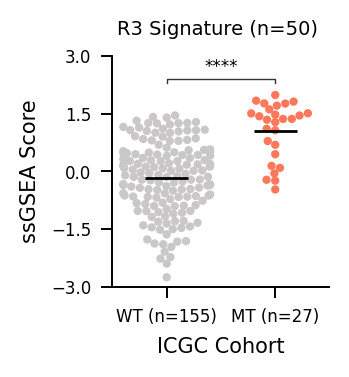

In [206]:
color = {'WT': control_color, 'MT': R3_color}
x = 'mutation_R3'
y = 'ssGSEA'
y_label = 'ssGSEA Score'
x_label = 'ICGC Cohort'
title = f'R3 Signature (n={len(R3_features_filtered)})'
print(f'Mutations: {muts_l}')
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, y_label=y_label, x_label=x_label, title=title, label_newline=False,title_fontsize=7, tick_fontsize=6, label_fontsize=7.5, ylim_top=3, ylim_bottom=-3, ytick_step=1.5, figure_width=1.4, figure_height=1.5, test='ranksum', save_figure=True)

Mutation_Signature  R3  R3 & R4  R4  WT
High_ssGSEA                            
R3 Enriched         17        1   6  22
Rest                 7        2  41  86
-------------------
High_ssGSEA         R3 Enriched  Rest
Mutation_Signature                   
R4                            7    43
WT                           39    93
Odds Ratio: 0.3881932021466905
P-value: 0.035726385493914346
There is a significant association between R4 and WT
WT wrt R4, p-value:
{('R4', 'WT'): 0.035726385493914346}
-------------------
High_ssGSEA         R3 Enriched  Rest
Mutation_Signature                   
R3                           18     9
WT                           28   127
Odds Ratio: 9.071428571428571
P-value: 8.274061583083273e-07
There is a significant association between R3 and WT
WT wrt R3, p-value:
{('R3', 'WT'): 8.274061583083273e-07}
-------------------
p-value= [8.274061583083273e-07, 0.035726385493914346]


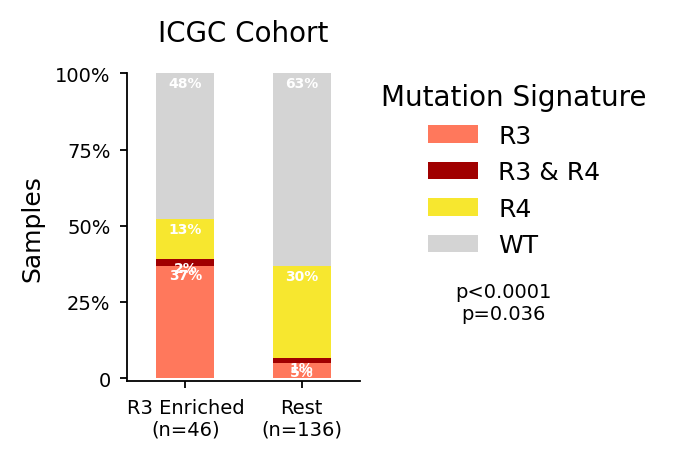

In [207]:
title = 'ICGC Cohort'
Utils.split_mutation_profiles(df, R3_muts_l=muts_l, R4_muts_l=R4_muts_l, color_dic=color_dic, title=title, file_name='ICGC_R3')

## ICGC - HNF1B

ranksum p-value=2.5771797141722836e-14
There is a significant association.


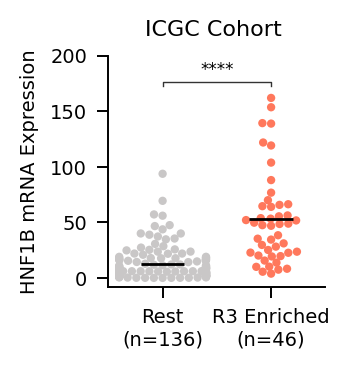

In [208]:
color = {'Rest':control_color, 'R3 Enriched':R3_color}
x = 'High_ssGSEA'
y = 'HNF1B'
y_label = 'HNF1B mRNA Expression'
title = 'ICGC Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum', y_label=y_label, title=title, label_newline=True, title_fontsize=8, ylim_top=200, ytick_step=50, title_height=1.0, tick_fontsize=7, label_fontsize=7.,figure_width=1.4, figure_height=1.5, save_figure=True)

## ICGC - CSGALNACT1

ranksum p-value=1.1113577937286888e-13
There is a significant association.


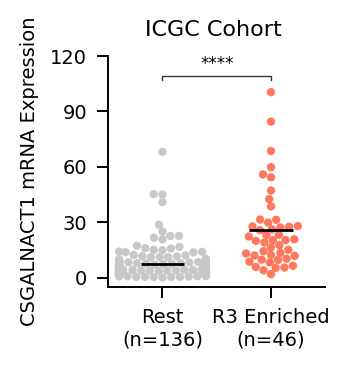

In [209]:
color = {'Rest': control_color, 'R3 Enriched':  R3_color}
x = 'High_ssGSEA'
y = 'CSGALNACT1'
y_label = 'CSGALNACT1 mRNA Expression'
title = 'ICGC Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum', y_label=y_label, label_newline=True, title=title, title_height=1.,title_fontsize=8, tick_fontsize=7,  ylim_top=120, ytick_step=30, label_fontsize=7., figure_width=1.4, figure_height=1.5, save_figure=True)

## ICGC - SULT1A1

ranksum p-value=5.646639150722362e-11
There is a significant association.


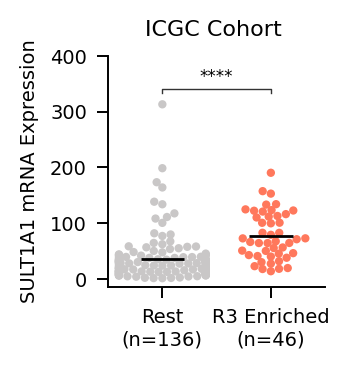

In [210]:
color = {'Rest': control_color, 'R3 Enriched':  R3_color}
x = 'High_ssGSEA'
y = 'SULT1A1'
y_label = 'SULT1A1 mRNA Expression'
title = 'ICGC Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum', y_label=y_label, label_newline=True, title=title, title_height=1.,title_fontsize=8, tick_fontsize=7, label_fontsize=7., ylim_top=400, ytick_step=100, figure_width=1.4, figure_height=1.5, save_figure=True)

## ICGC R3 Survival

In [211]:
icgc_R3_ssgsea_df['R3_ssGSEA'] = icgc_R3_ssgsea_df['High_ssGSEA'].replace({'R3 Enriched':1, 'Rest': 0})
surv_df = ICGC_info_df[['donor_survival_time', 'OS_event']].dropna(axis=0, how='all').astype(float)
surv_df['Group'] = 0#'Low ssGSEA'
surv_df.loc[icgc_R3_ssgsea_df.loc[surv_df.index, 'R3_ssGSEA'] ==1, 'Group'] = 1#'High ssGSEA'
surv_df.columns

Index(['donor_survival_time', 'OS_event', 'Group'], dtype='object', name='Gene_ID')

In [212]:
colors_l = ['#a00000','#077f97']
labels = ['Low', ' High']
MyRFunctions.survival_analysis(surv_df[['donor_survival_time', 'OS_event']], surv_df[['Group']], group='Group', cur_title=f'ICGC Cohort Overal Survival ({cluster} signature ssGSEA score)', legend_lbls=labels, colors_elms=colors_l, plot_path=os.path.join(io_library.output_dir, f'ICGC_Overal_Survival_Plot_{cluster}.pdf'))

0 119
1 42
------


## ssGSEA for R4 Signature

In [213]:
cluster ='R4'
R4_features_filtered = sorted(set(R4_features).intersection(set(exp_df.T.index)))
print('Shared features:', len(R4_features_filtered))

Shared features: 48


In [214]:
ssgsea_df = MyRFunctions.ssgsea(exp_df.T, R4_features_filtered)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [215]:
icgc_R4_ssgsea_df = zscore(ssgsea_df)
icgc_R4_ssgsea_df.head()

,ssGSEA
BD101,-0.088613
BD104,0.812237
BD105,-1.300263
BD109,-0.522945
BD10,0.623142


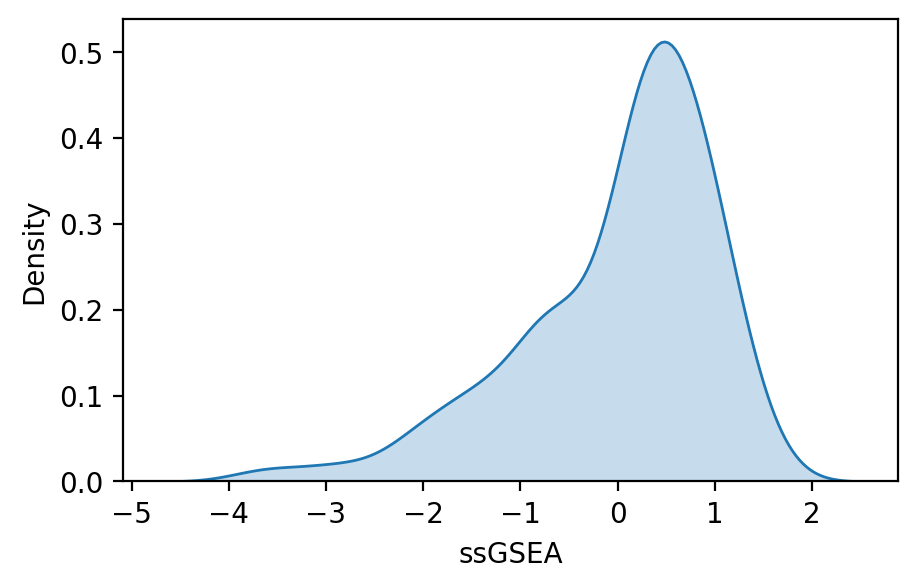

In [216]:
MyVisualization.plot_distribution(icgc_R4_ssgsea_df['ssGSEA'])

In [217]:
R4_threshold = np.percentile(icgc_R4_ssgsea_df['ssGSEA'], 75)
print('Enrichment cut-off:', R4_threshold) 
icgc_R4_ssgsea_df['High_ssGSEA'] = (icgc_R4_ssgsea_df['ssGSEA'] >= R4_threshold).astype(int)
icgc_R4_ssgsea_df['High_ssGSEA'] = icgc_R4_ssgsea_df['High_ssGSEA'].replace({0: 'Rest', 1: 'R4 Enriched'})
icgc_R4_ssgsea_df.head(10)

Enrichment cut-off: 0.6845142049575184


,ssGSEA,High_ssGSEA
BD101,-0.088613,Rest
BD104,0.812237,R4 Enriched
BD105,-1.300263,Rest
BD109,-0.522945,Rest
BD10,0.623142,Rest
BD111,0.468397,Rest
BD112,0.721878,R4 Enriched
BD114,0.406165,Rest
BD115,-0.947820,Rest
BD117,-0.906098,Rest


In [218]:
df = pd.concat([icgc_R4_ssgsea_df, icgc_mut_df], axis=1)
# MyLib.save_csv(df, 'FU_CCA_R3_ssGSEA_mutations_RNA.csv')

## R4 Mutation Signature comparison

Mutations: ['KRAS_MT', 'BRAF_MT', 'SMAD4_MT']
ranksum p-value=1.0703491869019606e-07
There is a significant association.


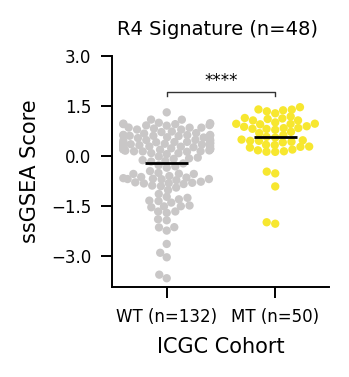

In [219]:
color = {'WT': control_color, 'MT': R4_color}
x = 'mutation_R4'
y = 'ssGSEA'
y_label = 'ssGSEA Score'
x_label = 'ICGC Cohort'
title = f'R4 Signature (n={len(R4_features_filtered)})'
print(f'Mutations: {R4_muts_l}')
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, y_label=y_label, x_label=x_label, title=title,
                                     label_newline=False, title_fontsize=7, tick_fontsize=6, label_fontsize=7.5,
                                     ylim_top=3., ytick_step=1.5, figure_width=1.4, figure_height=1.5,
                                     test='ranksum', save_figure=True)

Mutation_Signature  R3  R3 & R4  R4  WT
High_ssGSEA                            
R4 Enriched          3        0  25  18
Rest                21        3  22  90
-------------------
High_ssGSEA         R4 Enriched  Rest
Mutation_Signature                   
R4                           25    25
WT                           21   111
Odds Ratio: 5.285714285714286
P-value: 6.49222767083459e-06
There is a significant association between R4 and WT
WT wrt R4, p-value:
{('R4', 'WT'): 6.49222767083459e-06}
-------------------
High_ssGSEA         R4 Enriched  Rest
Mutation_Signature                   
R3                            3    24
WT                           43   112
Odds Ratio: 0.32558139534883723
P-value: 0.09154745063096964
There is no significant association between R3 and WT
WT wrt R3, p-value:
{('R3', 'WT'): 0.09154745063096964}
-------------------
p-value= [0.09154745063096964, 6.49222767083459e-06]


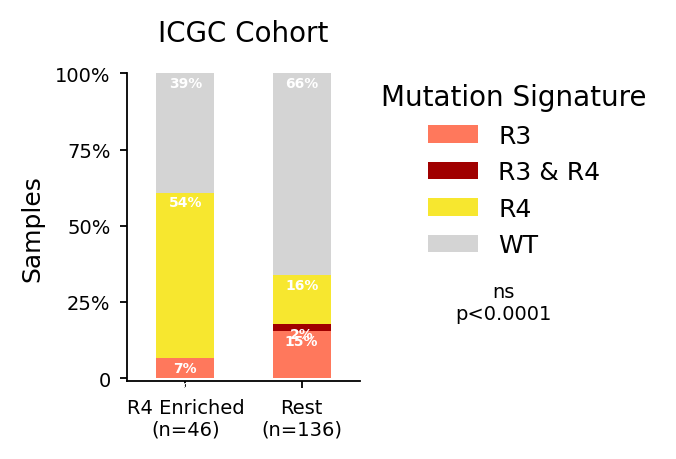

In [220]:
title = 'ICGC Cohort'
Utils.split_mutation_profiles(df, R3_muts_l=muts_l, R4_muts_l=R4_muts_l, color_dic=color_dic, title=title, file_name='ICGC_R4')

## ICGC R4 Survival

In [221]:
icgc_R4_ssgsea_df['R4_ssGSEA'] = icgc_R4_ssgsea_df['High_ssGSEA'].replace({'R4 Enriched':1, 'Rest': 0})
surv_df = ICGC_info_df[['donor_survival_time', 'OS_event']].dropna(axis=0, how='all').astype(float)
surv_df['Group'] = 0#'Low ssGSEA'
surv_df.loc[icgc_R4_ssgsea_df.loc[surv_df.index, 'R4_ssGSEA'] ==1, 'Group'] = 1#'High ssGSEA'
print(surv_df.shape)
surv_df.columns

(161, 3)


Index(['donor_survival_time', 'OS_event', 'Group'], dtype='object', name='Gene_ID')

In [222]:
colors_l = ['#a00000','#077f97']
labels = ['Low', ' High']
MyRFunctions.survival_analysis(surv_df[['donor_survival_time', 'OS_event']], surv_df[['Group']], group='Group',cur_title=f'ICGC Cohort Overal Survival ({cluster} signature ssGSEA score)', legend_lbls=labels, colors_elms=colors_l, plot_path=os.path.join(io_library.output_dir, f'ICGC_Overal_Survival_Plot_{cluster}.pdf'))

0 122
1 39
------


## CSGALNACT1

In [223]:
df = exp_df[['CSGALNACT1']].copy()
df['Group'] = (icgc_mut_df['BAP1_MT'] | icgc_mut_df['FGFR2_MT']).astype(int)
df['Group'] = df['Group'].replace({0: 'WT', 1: 'BAP1/FGFR2'})
df.columns

Index(['CSGALNACT1', 'Group'], dtype='object', name='Gene_ID')

In [224]:
df.shape

(182, 2)

ranksum p-value=0.007019984732525212
There is a significant association.


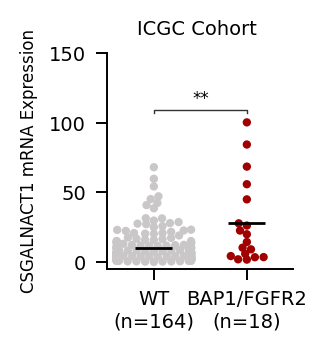

In [225]:
cur_color_dic = {'WT':'#c9c7c7', 'BAP1/FGFR2': '#A00000'}
x = 'Group'
gene = 'CSGALNACT1'
title = 'ICGC Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=gene, color_dic=cur_color_dic, y_label=f'{gene} mRNA Expression', test='ranksum', title=title, title_height=1.,title_fontsize=7, figure_width=1.2, figure_height=1.4, label_fontsize=6, ylim_top=150, ytick_step=50, label_newline=True, save_figure=True)

## TP63

Investigate the top expressed genes in cluster C6 of the CRISPR clustering.

In [226]:
C6_features = ['FAT2', 'CASP1', 'IRF6', 'KRT15', 'SERPINB13']

In [227]:
ssgsea_df = MyRFunctions.ssgsea(exp_df.T, C6_features)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [228]:
icgc_C6_ssgsea_df = zscore(ssgsea_df)
icgc_C6_ssgsea_df

,ssGSEA
BD101,-0.786086
BD104,0.788500
BD105,-0.421846
BD109,-0.565191
BD10,0.085113
...,...
BD91,-0.213450
BD92,0.252251
BD95,-0.259156
BD97,0.368555


In [229]:
df = pd.concat([icgc_C6_ssgsea_df, exp_df[['TP63']]], axis=1)
df.columns

Index(['ssGSEA', 'TP63'], dtype='object')

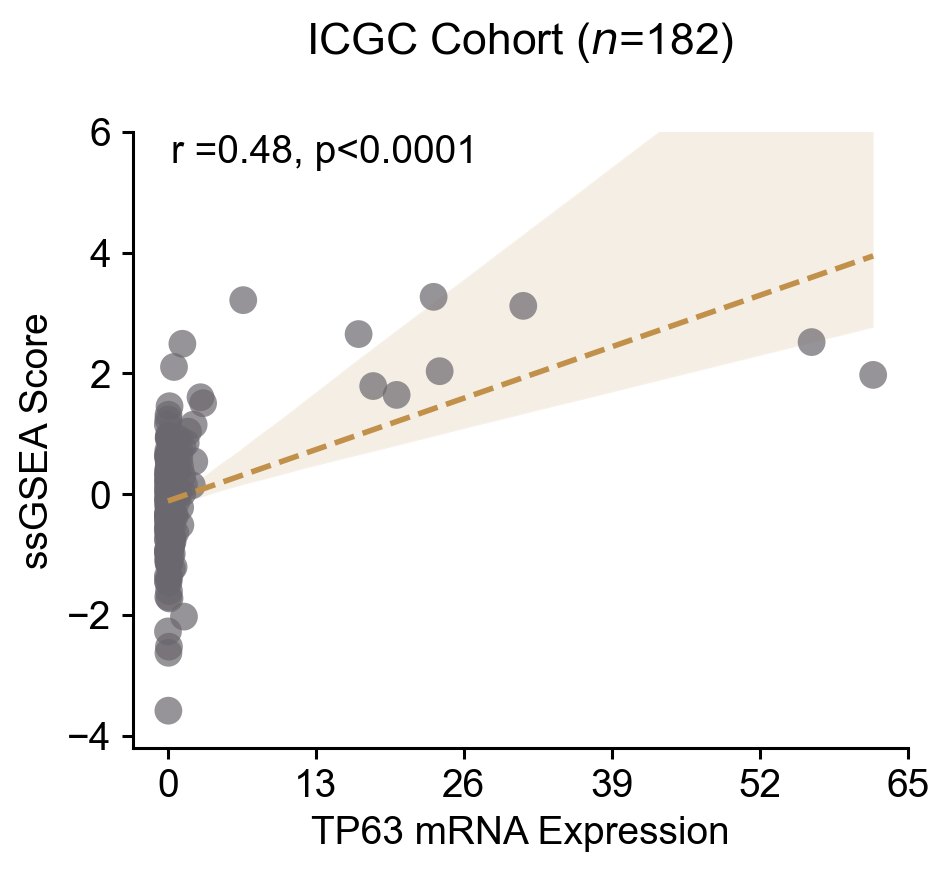

In [230]:
x = 'TP63'
y = 'ssGSEA'
points_color = '#6b676e'
line_color = '#C1914B'

MyVisualization.reg_plot(data_df=df, x_col=x, y_col=y, title=f'ICGC Cohort ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, ylabel='ssGSEA Score',  xlabel=f"{x} mRNA Expression" , marker='o', title_height=1.1, text_height=.95, ylim_top=6, xlim_right=65, xtick_step=13, file_name=f'ICGC_{x}_{y}')

### Patients stratification

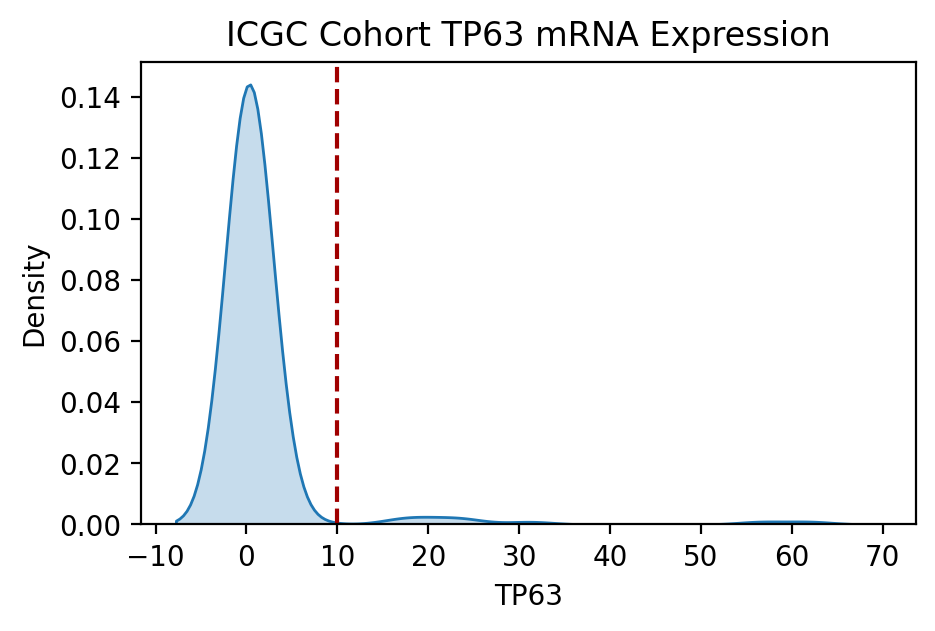

In [231]:
tp63_df = exp_df[['TP63']].copy()
MyVisualization.plot_distribution(tp63_df['TP63'], title='ICGC Cohort TP63 mRNA Expression', x_vline=10)

In [232]:
tp63_thr= 10 # distribution tail
top_tp63_df = tp63_df[tp63_df['TP63']>tp63_thr][['TP63']]
top_tp63_df.shape

(8, 1)

In [233]:
percentage = (top_tp63_df.shape[0]/df.shape[0])*100
print('Percentage of patients with high expression of TP63:', round(percentage, 2))

Percentage of patients with high expression of TP63: 4.4


In [234]:
tp63_df['TP63_High'] = (tp63_df['TP63']>tp63_thr).astype(int)
tp63_df['TP63_High']

BD101    0
BD104    0
BD105    0
BD109    0
BD10     0
        ..
BD91     0
BD92     0
BD95     0
BD97     0
BD9      0
Name: TP63_High, Length: 182, dtype: int64

### Save TP63 Results

In [235]:
tp63_all_df = pd.concat([tp63_df['TP63_High'], df['ssGSEA']], axis=1)
tp63_all_df

,TP63_High,ssGSEA
BD101,0,-0.786086
BD104,0,0.788500
BD105,0,-0.421846
BD109,0,-0.565191
BD10,0,0.085113
...,...,...
BD91,0,-0.213450
BD92,0,0.252251
BD95,0,-0.259156
BD97,0,0.368555


In [236]:
MyLib.save_csv(tp63_all_df, f'ICGC_TP63_mRNA_status_ssGSEA.csv')


File  patients_analysis/output_files_patients/ICGC_TP63_mRNA_status_ssGSEA.csv saved, shape: (182, 2)


## Save Results

In [237]:
icgc_R3_ssgsea_df

,ssGSEA,High_ssGSEA,R3_ssGSEA
BD101,1.215253,R3 Enriched,1
BD104,-0.031344,Rest,0
BD105,1.061743,R3 Enriched,1
BD109,1.001801,R3 Enriched,1
BD10,-0.264005,Rest,0
...,...,...,...
BD91,0.264046,Rest,0
BD92,1.102429,R3 Enriched,1
BD95,0.788191,Rest,0
BD97,0.169895,Rest,0


In [238]:
icgc_R4_ssgsea_df

,ssGSEA,High_ssGSEA,R4_ssGSEA
BD101,-0.088613,Rest,0
BD104,0.812237,R4 Enriched,1
BD105,-1.300263,Rest,0
BD109,-0.522945,Rest,0
BD10,0.623142,Rest,0
...,...,...,...
BD91,0.355801,Rest,0
BD92,-0.772299,Rest,0
BD95,0.138201,Rest,0
BD97,0.993659,R4 Enriched,1


In [239]:
d1 = icgc_R3_ssgsea_df[['ssGSEA', 'High_ssGSEA']]
d1 = d1.rename(columns={'ssGSEA':'R3_ssGSEA', 'High_ssGSEA':f'R3_status (thr={round(R3_threshold,3)})'})
d2 = icgc_R4_ssgsea_df[['ssGSEA', 'High_ssGSEA']]
d2 = d2.rename(columns={'ssGSEA':'R4_ssGSEA', 'High_ssGSEA':f'R4_status (thr={round(R4_threshold,3)}'})
df = pd.concat([d1, d2, icgc_mut_df[['mutation_R3', 'mutation_R4']], tp63_df['TP63_High']], axis=1)
MyLib.save_csv(df, 'ICGC_ssGSEA_mutations.csv')
# df = pd.concat([d1, d2, icgc_mut_df, exp_df], axis=1)
# MyLib.save_csv(df, 'ICGC_ssGSEA_mutations_RNA.csv')


File  patients_analysis/output_files_patients/ICGC_ssGSEA_mutations.csv saved, shape: (182, 7)


# FU-CCA dataset RNA
Deng, Mengjie, et al. "Proteogenomic characterization of cholangiocarcinoma." Hepatology 77.2 (2023): 411-429.
https://journals.lww.com/hep/fulltext/2023/02000/proteogenomic_characterization_of.11.aspx



In [240]:
FU_CCA_dataset_file = 'Patients_Data/FU-CCA/hep_2023_03_28_xu_hep-22-0042_sdc1.xlsx'
supp = pd.ExcelFile(os.path.join(io_library.input_dir, FU_CCA_dataset_file))

raw_info_df = supp.parse(supp.sheet_names[1])
raw_info_df['Tumor (T) RNA-seq ID'] = raw_info_df['Tumor (T) RNA-seq ID'].apply(lambda x: x.replace('_', '-').strip() if not pd.isna(x) else x)
raw_info_df['Patient No.'] = raw_info_df['Patient No.'].apply(lambda x: x.strip())
patient_rna_id_df = raw_info_df[['Patient No.', 'Tumor (T) RNA-seq ID']].dropna(axis=0)


mut_df = supp.parse(supp.sheet_names[2])
mut_df['Patient No.'] = mut_df['Patient No.'].apply(lambda x: x.strip())
mut_df.set_index('Patient No.', drop=True, inplace=True)
indices = sorted(set(mut_df.index).intersection(patient_rna_id_df['Patient No.'])) # Select samples that have both RNA-seq and mutation status.
fu_cca_mut_df = mut_df.loc[indices, ['IDH1', 'IDH2', 'BAP1', 'PBRM1', 'ARID1A', 'KRAS', 'SMAD4']].copy()
fu_cca_mut_df.columns = ['IDH1_MT', 'IDH2_MT', 'BAP1_MT', 'PBRM1_MT', 'ARID1A_MT', 'KRAS_MT','SMAD4_MT']
temp_df = patient_rna_id_df[patient_rna_id_df['Patient No.'].isin(indices)]
ids = dict(zip(temp_df['Tumor (T) RNA-seq ID'], temp_df['Patient No.']))

fusion_df = supp.parse(supp.sheet_names[11])
fusion_df.set_index('sample', drop=True, inplace=True)
fusion_df['LeftGene'] = fusion_df['LeftGene'].apply(lambda x: x.strip())
fusion_df['RightGene'] = fusion_df['RightGene'].apply(lambda x: x.strip())
fusion_df = fusion_df[(fusion_df['LeftGene']=='FGFR2') | (fusion_df['RightGene']=='FGFR2')]
fusion_ids = temp_df[temp_df['Tumor (T) RNA-seq ID'].isin(fusion_df.index)]['Patient No.'].tolist()
fu_cca_mut_df['FGFR2_MT'] = 0
fu_cca_mut_df.loc[fusion_ids, 'FGFR2_MT'] = 'Fusion'

raw_exp_df = supp.parse(supp.sheet_names[5])
raw_exp_df = raw_exp_df.rename(columns={'RNA-seq ID':'Gene'})
raw_exp_df.set_index('Gene', drop=True, inplace=True)
exp_df = raw_exp_df[temp_df['Tumor (T) RNA-seq ID']] # Select samples that have mutations data
exp_df = exp_df.rename(columns={col:ids[col] for col in exp_df.columns})
exp_df = exp_df.T.astype(float)
exp_df = exp_df.dropna(axis=1)
exp_df = exp_df.T[~exp_df.T.index.duplicated(keep='first')] # Dataset contains duplicate genes
print('mRNA with mutation data shape', exp_df.shape)

ids = dict(zip(patient_rna_id_df['Tumor (T) RNA-seq ID'], patient_rna_id_df['Patient No.']))
all_exp_df = raw_exp_df[patient_rna_id_df['Tumor (T) RNA-seq ID']]
all_exp_df = all_exp_df.rename(columns={col:ids[col] for col in all_exp_df.columns})
all_exp_df = all_exp_df.T.astype(float)
all_exp_df = all_exp_df.dropna(axis=1)
all_exp_df = all_exp_df.T[~all_exp_df.T.index.duplicated(keep='first')]# dataset contains duplicate genes
print('mRNA data shape', all_exp_df.shape)

info_df = raw_info_df.set_index('Patient No.', drop=True)
info_df = info_df[info_df.index.isin(all_exp_df.columns)]

mRNA with mutation data shape (12666, 94)
mRNA data shape (12666, 126)


Add columns for mutation signatures

In [241]:
fu_cca_mut_df = fu_cca_mut_df.fillna(0)
fu_cca_mut_df[fu_cca_mut_df != 0] = 1
muts_l = ['IDH1_MT','IDH2_MT', 'BAP1_MT', 'FGFR2_MT']
fu_cca_mut_df['mutation_R3'] = (fu_cca_mut_df['IDH1_MT'] | fu_cca_mut_df['IDH2_MT'] | fu_cca_mut_df['BAP1_MT'] | fu_cca_mut_df['FGFR2_MT']).astype(int)
fu_cca_mut_df['mutation_R3'] = fu_cca_mut_df['mutation_R3'].replace({0: 'WT', 1: 'MT'})

R4_muts_l= ['KRAS_MT', 'SMAD4_MT'] 
fu_cca_mut_df['mutation_R4'] = (fu_cca_mut_df['KRAS_MT'] | fu_cca_mut_df['SMAD4_MT']).astype(int)
fu_cca_mut_df['mutation_R4'] = fu_cca_mut_df['mutation_R4'].replace({0: 'WT', 1: 'MT'})
fu_cca_mut_df.head(10)

,IDH1_MT,IDH2_MT,BAP1_MT,PBRM1_MT,ARID1A_MT,KRAS_MT,SMAD4_MT,FGFR2_MT,mutation_R3,mutation_R4
Patient No.,,,,,,,,,,
CCA#101,0,0,0,0,0,0,0,0,WT,WT
CCA#102,0,0,0,0,0,0,0,0,WT,WT
CCA#103,0,0,0,0,0,1,1,0,WT,MT
CCA#105,0,0,0,0,0,0,0,0,WT,WT
CCA#110,0,0,0,0,0,0,0,0,WT,WT
CCA#112,0,0,0,1,0,0,0,0,WT,WT
CCA#115,0,0,0,0,0,0,0,0,WT,WT
CCA#116,0,0,0,0,0,0,0,0,WT,WT
CCA#119,0,0,0,0,0,0,0,0,WT,WT


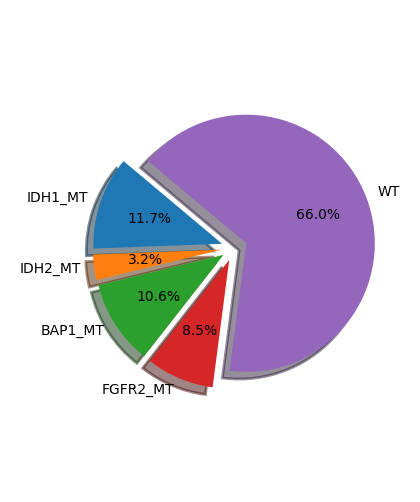

In [242]:
Utils.piechart(fu_cca_mut_df[['IDH1_MT', 'IDH2_MT', 'BAP1_MT', 'FGFR2_MT']])

## ssGSEA for R3 Signature

Among the R3 features, there are 12 genes that are not included in the dataset:
 ['PPBP', 'SPNS3', 'ALAS2', 'FXYD2', 'GUCA2B', 'DMBT1', 'KLHDC7A', 'SEC14L6', 'RHAG', 'PGBD5', 'SLC17A3', 'SLC35F3']


In [243]:
R3_features_filtered = sorted(set(R3_features).intersection(set(exp_df.index)))
print('Shared features:', len(R3_features_filtered))

Shared features: 34


In [244]:
ssgsea_df = MyRFunctions.ssgsea(exp_df, R3_features_filtered)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [245]:
FU_CCA_R3_ssgsea_df = zscore(ssgsea_df)
FU_CCA_R3_ssgsea_df.head(10)

,ssGSEA
CCA#20,-1.704494
CCA#21,-1.001702
CCA#22,-1.354439
CCA#23,-1.171998
CCA#30,0.404393
CCA#31,-0.142794
CCA#32,-0.168574
CCA#33,0.526238
CCA#34,0.880163
CCA#35,1.038444


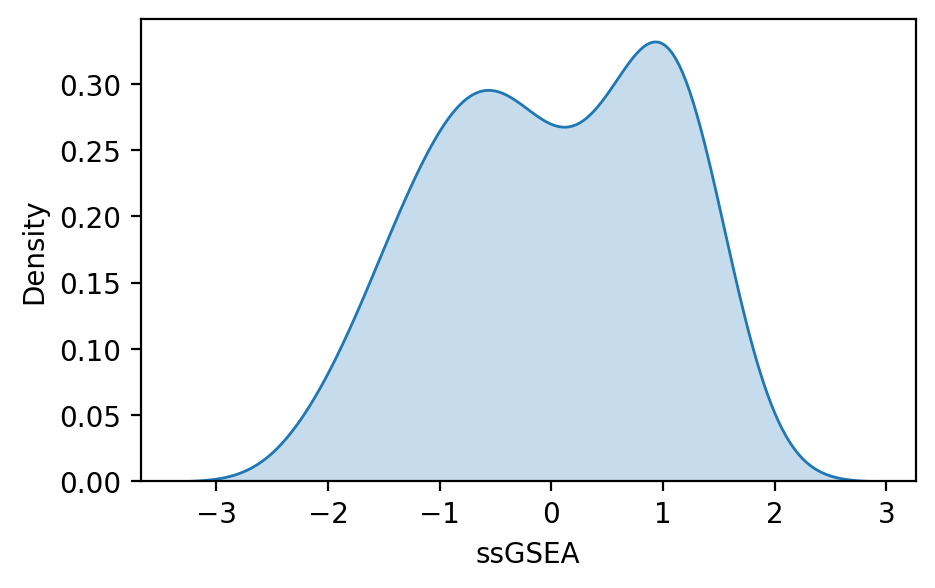

In [246]:
MyVisualization.plot_distribution(FU_CCA_R3_ssgsea_df['ssGSEA'])

In [247]:
R3_threshold = np.percentile(FU_CCA_R3_ssgsea_df['ssGSEA'], 75)
print('Enrichment cut-off:', R3_threshold) 
FU_CCA_R3_ssgsea_df['High_ssGSEA'] = (FU_CCA_R3_ssgsea_df['ssGSEA'] >= R3_threshold).astype(int)
FU_CCA_R3_ssgsea_df['High_ssGSEA'] = FU_CCA_R3_ssgsea_df['High_ssGSEA'].replace({0: 'Rest', 1: 'R3 Enriched'})
FU_CCA_R3_ssgsea_df.head(10)

Enrichment cut-off: 0.9393713760375884


,ssGSEA,High_ssGSEA
CCA#20,-1.704494,Rest
CCA#21,-1.001702,Rest
CCA#22,-1.354439,Rest
CCA#23,-1.171998,Rest
CCA#30,0.404393,Rest
CCA#31,-0.142794,Rest
CCA#32,-0.168574,Rest
CCA#33,0.526238,Rest
CCA#34,0.880163,Rest
CCA#35,1.038444,R3 Enriched


In [248]:
df = pd.concat([FU_CCA_R3_ssgsea_df, fu_cca_mut_df, exp_df.T], axis=1)
# MyLib.save_csv(df, 'FU_CCA_R3_ssGSEA_mutations_RNA.csv')
df = df.sort_values(by=['ssGSEA'], ascending=False)

### R3 Mutation Signature comparison

Mutations: ['IDH1_MT', 'IDH2_MT', 'BAP1_MT', 'FGFR2_MT']
ranksum p-value=0.0011712982611074803
There is a significant association.


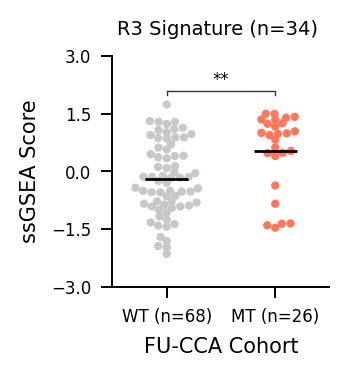

In [249]:
color = {'WT': control_color, 'MT': R3_color}
x = 'mutation_R3'
y = 'ssGSEA'
y_label = 'ssGSEA Score'
x_label = 'FU-CCA Cohort'
title = f'R3 Signature (n={len(R3_features_filtered)})'
print('Mutations:', muts_l)
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, y_label=y_label, x_label=x_label, title=title, label_newline=False,title_fontsize=7, tick_fontsize=6, label_fontsize=7.5, ylim_top=3., ylim_bottom=-3, ytick_step=1.5, figure_width=1.4, figure_height=1.5, test='ranksum', save_figure=True)


Mutation_Signature  R3  R3 & R4  R4  WT
High_ssGSEA                            
R3 Enriched         13        0   0  11
Rest                12        1  14  43
-------------------
High_ssGSEA         R3 Enriched  Rest
Mutation_Signature                   
R4                            0    15
WT                           24    55
Odds Ratio: 0.0
P-value: 0.009888310914048255
There is a significant association between R4 and WT
WT wrt R4, p-value:
{('R4', 'WT'): 0.009888310914048255}
-------------------
High_ssGSEA         R3 Enriched  Rest
Mutation_Signature                   
R3                           13    13
WT                           11    57
Odds Ratio: 5.181818181818182
P-value: 0.0014134396149741522
There is a significant association between R3 and WT
WT wrt R3, p-value:
{('R3', 'WT'): 0.0014134396149741522}
-------------------
p-value= [0.0014134396149741522, 0.009888310914048255]


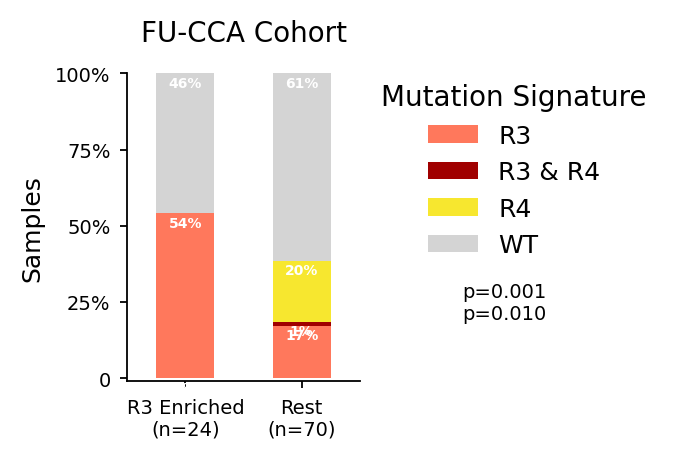

In [250]:
title = 'FU-CCA Cohort'
Utils.split_mutation_profiles(df, R3_muts_l=muts_l, R4_muts_l=R4_muts_l, color_dic=color_dic, title=title, file_name='FU_CCA_R3')

### HNF1B - RNA

ranksum p-value=4.12738426761698e-09
There is a significant association.


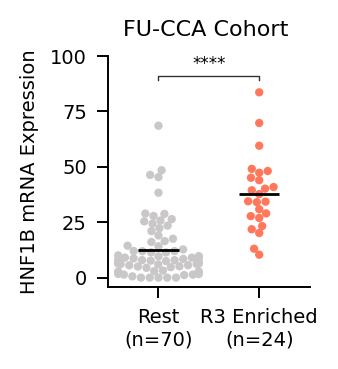

In [251]:
color = {'Rest': control_color, 'R3 Enriched': R3_color}
x = 'High_ssGSEA'
y = 'HNF1B'
y_label = 'HNF1B mRNA Expression'
title = 'FU-CCA Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum', y_label=y_label, title=title, label_newline=True, title_fontsize=8, ylim_top=100, ytick_step=25, title_height=1.0, tick_fontsize=7, label_fontsize=7.,figure_width=1.3, figure_height=1.5, save_figure=True)

### CSGALNACT1 - RNA

ranksum p-value=0.00012678259238580074
There is a significant association.


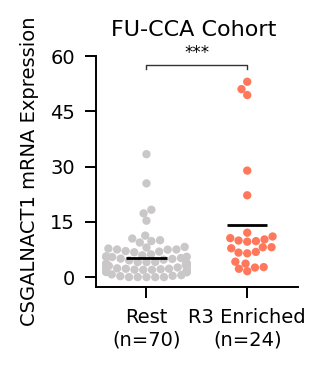

In [252]:
color = {'Rest': control_color, 'R3 Enriched': R3_color}
x = 'High_ssGSEA'
y = 'CSGALNACT1'
y_label = f'{y} mRNA Expression'
title = 'FU-CCA Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum', y_label=y_label, title=title, label_newline=True, title_fontsize=8, ylim_top=60, ytick_step=15, title_height=1.0, tick_fontsize=7, label_fontsize=7.,figure_width=1.3, figure_height=1.5, save_figure=True)

### SULT1A1 - RNA

ranksum p-value=0.011916111052106743
There is a significant association.


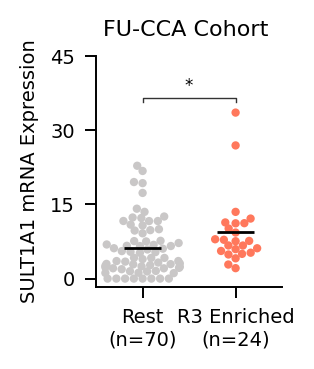

In [253]:
color = {'Rest': control_color, 'R3 Enriched': R3_color}
x = 'High_ssGSEA'
y = 'SULT1A1'
y_label = 'SULT1A1 mRNA Expression'
title = 'FU-CCA Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum', y_label=y_label, title=title, label_newline=True, title_fontsize=8, ylim_top=45, ytick_step=15, title_height=1.0, tick_fontsize=7, label_fontsize=7.,figure_width=1.2, figure_height=1.5, save_figure=True)

### FU-CCA R3 Survival

Use the larger dataset that contains all samples with expression values and survival data.

In [254]:
all_exp_df.shape

(12666, 126)

In [255]:
cluster = 'R3'
ssgsea_df = MyRFunctions.ssgsea(all_exp_df, R3_features_filtered)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [256]:
all_FU_CCA_R3_ssgsea_df = zscore(ssgsea_df)
all_FU_CCA_R3_ssgsea_df.head(10)

,ssGSEA
CCA#2,-0.050646
CCA#4,-1.404275
CCA#9,-1.450207
CCA#11,0.210391
CCA#12,-1.593675
CCA#13,-1.028968
CCA#14,-0.497135
CCA#15,-0.814821
CCA#20,-1.487285
CCA#21,-0.791708


In [257]:
threshold = np.percentile(all_FU_CCA_R3_ssgsea_df['ssGSEA'], 75)
# threshold=0
print('R3 Enrichment cut-off:', threshold)
all_FU_CCA_R3_ssgsea_df['R3_ssGSEA'] = (all_FU_CCA_R3_ssgsea_df['ssGSEA'] >= threshold).astype(int)
# all_FU_CCA_R3_ssgsea_df['R3_ssGSEA'] = all_FU_CCA_R3_ssgsea_df['R3_ssGSEA'].replace({0: 'Rest', 1: 'R3 Enriched'})

R3 Enrichment cut-off: 0.9211864678207146


In [258]:
surv_df = info_df[['Overall survival(day)', 'Survival(1,dead;0,alive)']].dropna(axis=0, how='all').astype(float)
surv_df['Group'] = 0#'Low ssGSEA'
surv_df.loc[all_FU_CCA_R3_ssgsea_df.loc[surv_df.index, 'R3_ssGSEA'] ==1, 'Group'] = 1#'High ssGSEA'
surv_df.head()

,Overall survival(day),"Survival(1,dead;0,alive)",Group
Patient No.,,,
CCA#2,1216.0,1.0,0
CCA#4,437.0,1.0,0
CCA#11,222.0,1.0,0
CCA#12,391.0,1.0,0
CCA#13,170.0,1.0,0


In [259]:
info_filtered_df = info_df.rename(columns={'Tumor size (cm)':'Tumor size', 'Preoperative CA19-9（U/ml）':'Preoperative CA19-9', 'Preoperative CEA（ng/ml）':'Preoperative CEA', 'TB, total bilirubin (µmol/L)':'TB total bilirubin', 'Perineural invasion (PNI)':'Perineural invasion', 'Lymphovascular invasion (LVI)':'Lymphovascular invasion'})# R cannot take -

In [260]:
cont_feats_cols = ['Age', 'Tumor size', 'Preoperative CA19-9', 'Preoperative CEA', 'TB total bilirubin']
cat_feats_cols = ['Gender', 'Anatomical classification', 'Histology', 'iCCA classification', 'HBsAg','Cholelithiasis', 'Jaundice', 'Type II diabetes', 'Hypertension', 'Presence of fluke infection', 'Perineural invasion', 'Lymphovascular invasion', 'eccStage', 'iccStage', ]#'Grade'

In [261]:
info_filtered_df['iCCA classification'] = info_filtered_df['iCCA classification'].fillna('other')
info_filtered_df['eccStage'] = info_filtered_df['eccStage'].fillna('other')
info_filtered_df['iccStage'] = info_filtered_df['iccStage'].fillna('other')
info_filtered_df['Preoperative CA19-9'] = info_filtered_df['Preoperative CA19-9'].replace('<0.6', 0.59)
info_filtered_df['Preoperative CA19-9'] = info_filtered_df['Preoperative CA19-9'].replace('>10000', 10001)

In [262]:
info_filtered_df[cont_feats_cols] = info_filtered_df[cont_feats_cols].replace('Unknown', np.nan)
info_filtered_df2= info_filtered_df[cont_feats_cols+cat_feats_cols].dropna()
info_filtered_df2, surv_filtered_df = Utils.match_rows_df(info_filtered_df2, surv_df)
info_filtered_df2.shape

(114, 19)

Only 114 out of 122 patients with survival data 

#### Kaplan-Meier

In [263]:
colors_l = ['#a00000','#077f97']
labels = ['Low', ' High']
MyRFunctions.survival_analysis(surv_filtered_df[['Overall survival(day)', 'Survival(1,dead;0,alive)']], surv_filtered_df[['Group']], 'Group', f'FU-CCA Cohort Overal Survival ({cluster} ssGSEA score)', legend_lbls=labels, colors_elms=colors_l, plot_path=os.path.join(io_library.output_dir, f'FU_CCA_Overal_Survival_Plot_{cluster}.pdf'))

0 83
1 31
------


#### Cox Regression

Assess the impact of ssGSEA scores while adjusting for other covariates, and demonstrating that they are not confounding the relationship between ssGSEA scores and survival.

In [264]:
cat_clinical_feats_df = Utils.create_onehot_encoding_columns(info_filtered_df2, cat_feats_cols)

Gender
Reference level: Gender_Female
------
Anatomical classification
Reference level: Anatomical classification_hilar/perihilar
------
Histology
Reference level: Histology_eCCA
------
iCCA classification
Reference level: other
------
HBsAg
Reference level: Unknown
------
Cholelithiasis
Reference level: Cholelithiasis_No
------
Jaundice
Reference level: Jaundice_No
------
Type II diabetes
Reference level: Type II diabetes_No
------
Hypertension
Reference level: Hypertension_No
------
Presence of fluke infection
Reference level: Presence of fluke infection_No
------
Perineural invasion
Reference level: Unknown
------
Lymphovascular invasion
Reference level: Unknown
------
eccStage
Reference level: other
------
iccStage
Reference level: other
------


In [265]:
all_clinical_feats_df = pd.concat([all_FU_CCA_R3_ssgsea_df.loc[info_filtered_df2.index, ['ssGSEA']], info_filtered_df2[cont_feats_cols], cat_clinical_feats_df], axis=1)
all_clinical_feats_df = all_clinical_feats_df.rename(columns={'ssGSEA':'R3_ssGSEA'})
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace('-', '_') for col in all_clinical_feats_df.columns})# R cannot take -
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace(' ', '_') for col in all_clinical_feats_df.columns})# R cannot take space
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace('/', '_') for col in all_clinical_feats_df.columns})# R cannot take /
all_clinical_feats_df = all_clinical_feats_df.astype(float)

In [266]:
# MyLib.save_csv(surv_filtered_df, 'survival.csv')
# MyLib.save_csv(all_clinical_feats_df, 'all_clinical_feats_df.csv')

In [267]:
all_clinical_feats_df

,R3_ssGSEA,Age,Tumor_size,Preoperative_CA19_9,Preoperative_CEA,TB_total_bilirubin,Gender_Male,Anatomical_classification_intrahepatic,Histology_iCCA,iCCA_classification_Unknown,...,eccStage_IIIA,eccStage_IIIB,eccStage_IIIC,eccStage_IVB,iccStage_IA,iccStage_IB,iccStage_II,iccStage_IIIA,iccStage_IIIB,iccStage_IV
Patient No.,,,,,,,,,,,,,,,,,,,,,
CCA#101,1.041364,71.0,4.0,54.7,3.40,11.4,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CCA#102,0.153787,61.0,1.2,11.9,2.00,9.5,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
CCA#105,1.155743,62.0,3.3,1.9,7.60,10.5,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CCA#11,0.210391,55.0,7.0,624.6,4.66,331.9,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
CCA#110,-0.049067,62.0,4.5,233.7,3.40,7.1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCA#92,-0.578241,56.0,4.0,171.0,7.40,93.7,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCA#93,0.311062,65.0,4.0,414.5,3.80,11.5,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
CCA#94,1.071198,61.0,5.0,0.7,1.20,14.7,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [268]:
all_clinical_feats_df = all_clinical_feats_df.drop(['iCCA_classification_small_iBD', 'eccStage_IVB', 'Anatomical_classification_intrahepatic', 'iccStage_IV'], axis=1)#

In [269]:
MyRFunctions.find_collinearity(all_clinical_feats_df.drop(['Gender_Male'], axis=1), all_clinical_feats_df[['Gender_Male']]) # removed 'Grade'

Model :
Gender_Male ~ R3_ssGSEA + Age + Tumor_size + Preoperative_CA19_9 + 
    Preoperative_CEA + TB_total_bilirubin + Histology_iCCA + 
    iCCA_classification_Unknown + iCCA_classification_large_iBD + 
    HBsAg_Negative + HBsAg_Positive + Cholelithiasis_Yes + Jaundice_Yes + 
    Type_II_diabetes_Yes + Hypertension_Yes + Presence_of_fluke_infection_Yes + 
    Perineural_invasion_No + Perineural_invasion_Yes + Lymphovascular_invasion_No + 
    Lymphovascular_invasion_Yes + eccStage_II + eccStage_IIIA + 
    eccStage_IIIB + eccStage_IIIC + iccStage_IA + iccStage_IB + 
    iccStage_II + iccStage_IIIA + iccStage_IIIB



In [270]:
coxph_mv_df = MyRFunctions.coxph_multivariate(surv_filtered_df[['Overall survival(day)', 'Survival(1,dead;0,alive)']], all_clinical_feats_df)
coxph_mv_df

[1] "AIC of cox model:  654.18368094741"
[1] "Proportional Hazards Assumption: "
                                       chisq df           p
R3_ssGSEA                        0.032498379  1 0.856938199
Age                              0.177839433  1 0.673236610
Tumor_size                       0.075840523  1 0.783015412
Preoperative_CA19_9              2.308134871  1 0.128698395
Preoperative_CEA                10.485697667  1 0.001203022
TB_total_bilirubin               0.292462570  1 0.588646762
Gender_Male                      0.111929869  1 0.737957615
Histology_iCCA                   0.693980256  1 0.404813839
iCCA_classification_Unknown      0.005945078  1 0.938540546
iCCA_classification_large_iBD    2.179480479  1 0.139861667
HBsAg_Negative                   0.021872969  1 0.882425534
HBsAg_Positive                   0.126962047  1 0.721602924
Cholelithiasis_Yes               0.023747234  1 0.877529803
Jaundice_Yes                     0.082913743  1 0.773386953
Type_II_diabetes_Ye

,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,R3_ssGSEA,-0.485579,0.615341,0.177199,-2.740305,0.006138,0.434794,0.870859,-0.832883,-0.138276,0.092073
1,iCCA_classification_Unknown,1.376551,3.961215,0.495573,2.777697,0.005475,1.499672,10.463107,0.405246,2.347855,0.092073
2,Jaundice_Yes,-1.933636,0.144621,0.757236,-2.553547,0.010663,0.032785,0.637959,-3.417791,-0.449482,0.106632
3,Preoperative_CA19_9,0.000206,1.000206,0.00009,2.293349,0.021828,1.00003,1.000383,0.000030,0.000383,0.130968
4,TB_total_bilirubin,0.006246,1.006265,0.002643,2.363426,0.018107,1.001067,1.011491,0.001066,0.011425,0.130968
5,iccStage_IA,-3.253716,0.03863,1.531377,-2.1247,0.033612,0.001921,0.777033,-6.255160,-0.252272,0.168058
6,iccStage_IB,-2.7784,0.062138,1.52254,-1.824845,0.068024,0.003143,1.228415,-5.762525,0.205724,0.2474
7,eccStage_IIIC,-2.566303,0.076819,1.508452,-1.701282,0.08889,0.003995,1.477289,-5.522815,0.390209,0.2474
8,iccStage_IIIA,-2.702756,0.067021,1.558146,-1.734598,0.082812,0.003162,1.420706,-5.756666,0.351154,0.2474
9,iccStage_IIIB,-3.168358,0.042073,1.769822,-1.790213,0.07342,0.001311,1.350438,-6.637145,0.300429,0.2474


<Figure size 500x700 with 0 Axes>

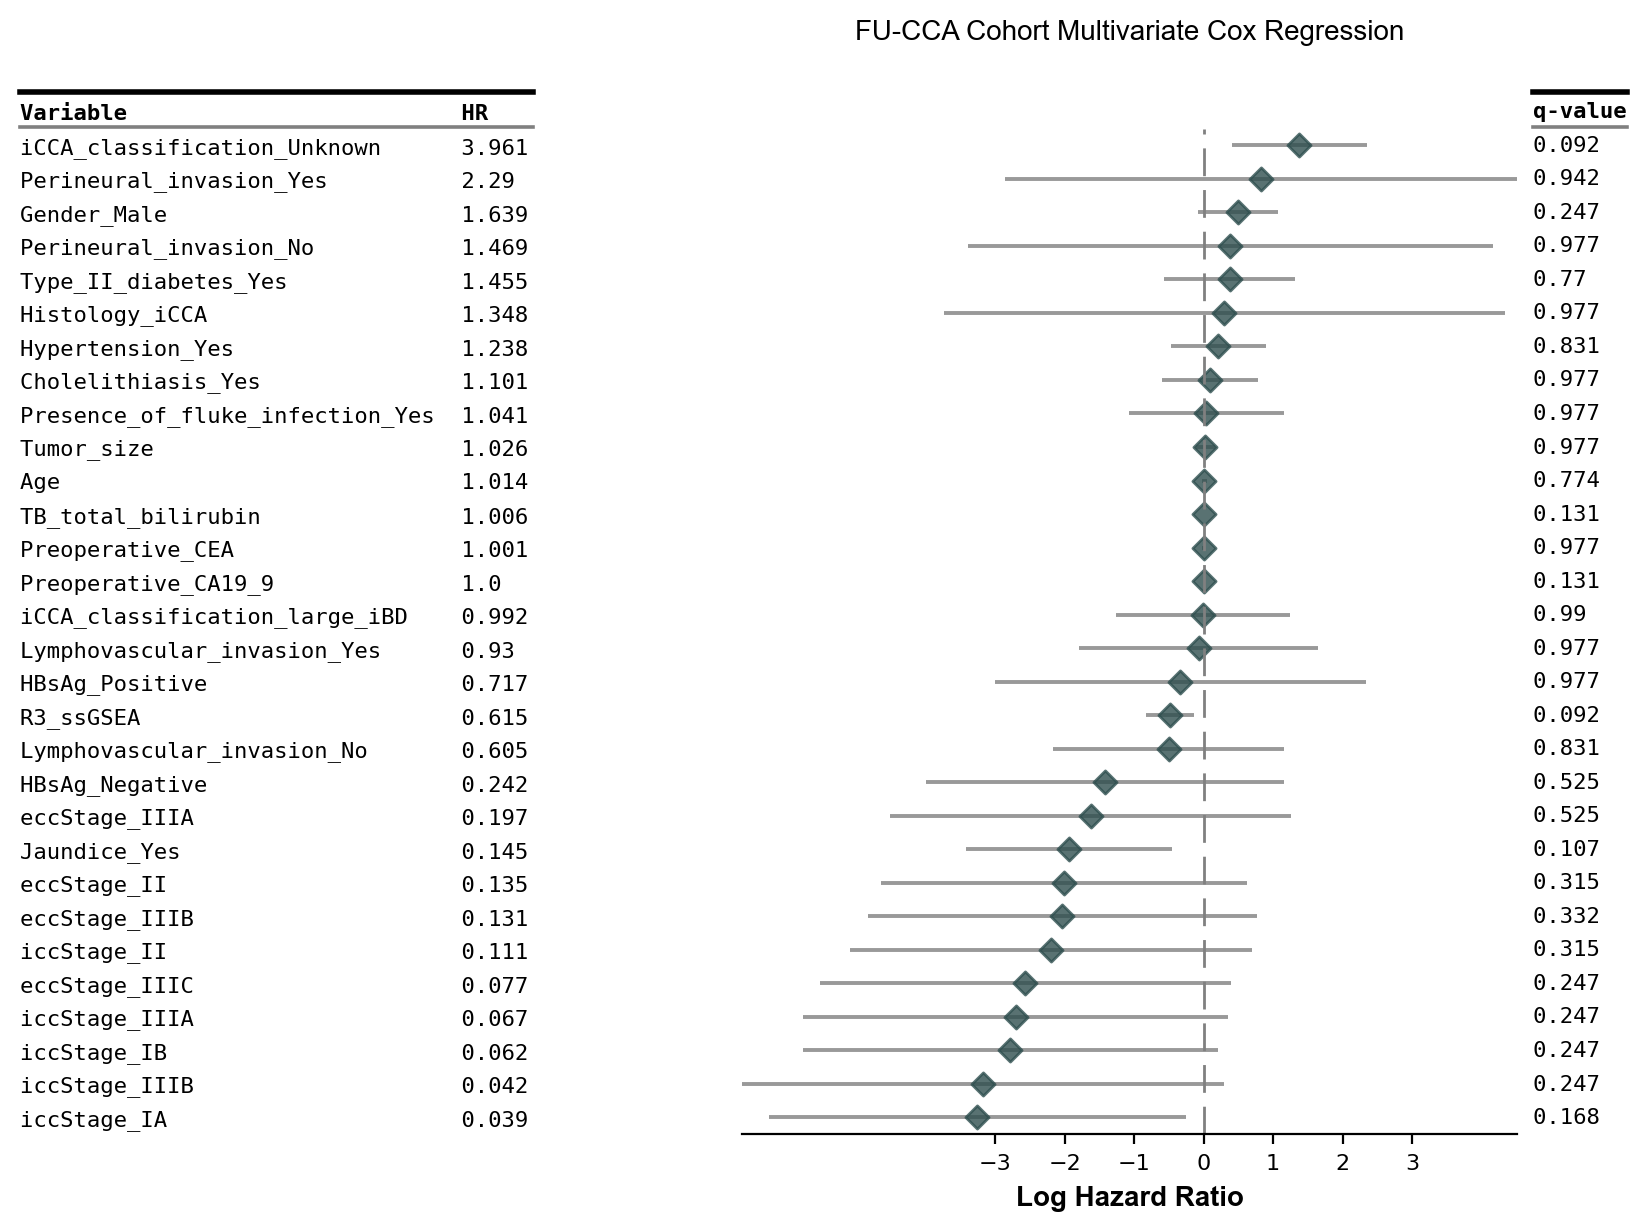

In [271]:
MyVisualization.forest_plot(coxph_mv_df, title='FU-CCA Cohort Multivariate Cox Regression')

In [272]:
coxph_uni_df = MyRFunctions.coxph_multivariate(surv_filtered_df, all_FU_CCA_R3_ssgsea_df.loc[info_filtered_df2.index, ['R3_ssGSEA']])
coxph_uni_df

[1] "AIC of cox model:  661.470883538003"
[1] "Proportional Hazards Assumption: "
               chisq df         p
R3_ssGSEA 0.01447473  1 0.9042368
GLOBAL    0.01447473  1 0.9042368


,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,R3_ssGSEA,-1.177865,0.307936,0.305629,-3.853905,0.000116,0.169164,0.560546,-1.776887,-0.578843,0.000116


ssGSEA is significant in both multivariate and univariate analyses. The hazard ratio of ssGSEA in the multivariate model differs slightly with the univariate model, indicating that other covariates have a minimal impact. This suggests that the relationship between ssGSEA scores and survival is not confounded by other covariates.


In [273]:
MyLib.save_csv(coxph_mv_df, 'FU_CCA_cox_mutlivariate_R3_ssGSEA.csv', index=False)


File  patients_analysis/output_files_patients/FU_CCA_cox_mutlivariate_R3_ssGSEA.csv saved, shape: (30, 11)


## ssGSEA for R4 Signature

In [274]:
cluster = 'R4'
R4_features_filtered = sorted(set(R4_features).intersection(set(exp_df.index)))
print('Shared features:', len(R4_features_filtered))

Shared features: 30


In [275]:
ssgsea_df = MyRFunctions.ssgsea(exp_df, R4_features_filtered)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [276]:
FU_CCA_R4_ssgsea_df = zscore(ssgsea_df)
FU_CCA_R4_ssgsea_df.head(10)

,ssGSEA
CCA#20,0.190771
CCA#21,1.134242
CCA#22,-0.346277
CCA#23,1.971387
CCA#30,-0.334695
CCA#31,1.276996
CCA#32,0.306986
CCA#33,-0.265609
CCA#34,0.654583
CCA#35,-0.807681


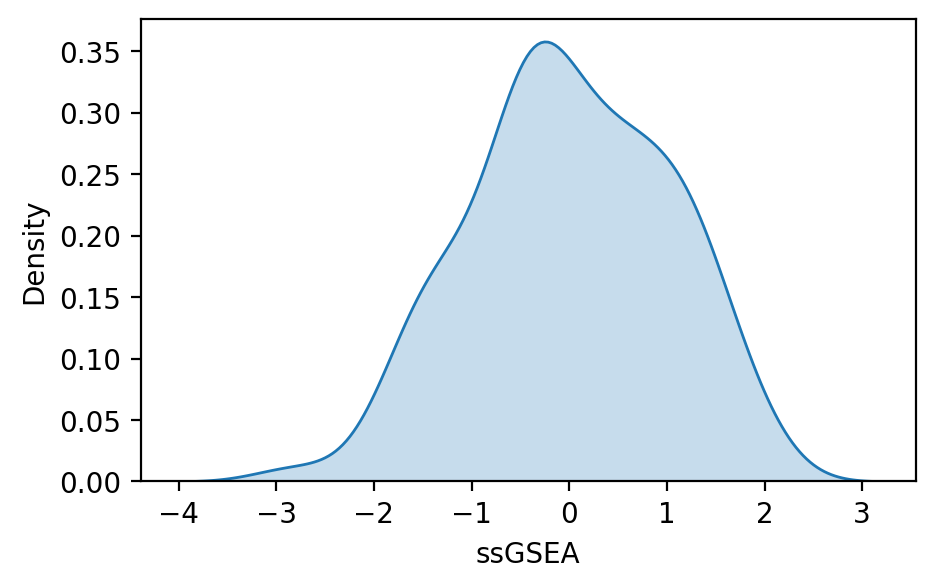

In [277]:
MyVisualization.plot_distribution(FU_CCA_R4_ssgsea_df['ssGSEA'])

In [278]:
R4_threshold = np.percentile(FU_CCA_R4_ssgsea_df['ssGSEA'], 75)
print('Enrichment cut-off:', R4_threshold) 
FU_CCA_R4_ssgsea_df['High_ssGSEA'] = (FU_CCA_R4_ssgsea_df['ssGSEA'] > R4_threshold).astype(int)
FU_CCA_R4_ssgsea_df['High_ssGSEA'] = FU_CCA_R4_ssgsea_df['High_ssGSEA'].replace({0: 'Rest', 1: 'R4 Enriched'})
FU_CCA_R4_ssgsea_df.head(10)

Enrichment cut-off: 0.723840504313161


,ssGSEA,High_ssGSEA
CCA#20,0.190771,Rest
CCA#21,1.134242,R4 Enriched
CCA#22,-0.346277,Rest
CCA#23,1.971387,R4 Enriched
CCA#30,-0.334695,Rest
CCA#31,1.276996,R4 Enriched
CCA#32,0.306986,Rest
CCA#33,-0.265609,Rest
CCA#34,0.654583,Rest
CCA#35,-0.807681,Rest


In [279]:
df_R4 = pd.concat([FU_CCA_R4_ssgsea_df, fu_cca_mut_df, exp_df.T], axis=1)
# MyLib.save_csv(df, 'FU_CCA_R3_ssGSEA_mutations_RNA.csv')
df_R4 = df_R4.sort_values(by=['ssGSEA'], ascending=False)

### R4 Mutation Signature comparison

Mutations: ['KRAS_MT', 'SMAD4_MT']
ranksum p-value=0.000669123664952085
There is a significant association.


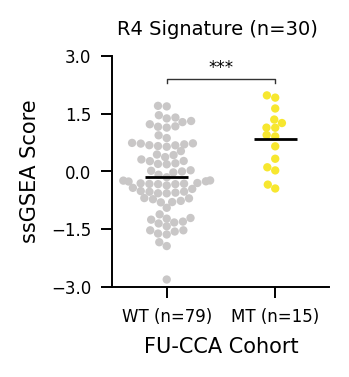

In [280]:
color = {'WT': control_color, 'MT': R4_color}
x = 'mutation_R4'
y = 'ssGSEA'
y_label = 'ssGSEA Score'
x_label = 'FU-CCA Cohort'
title = f'R4 Signature (n={len(R4_features_filtered)})'
print('Mutations:', R4_muts_l)
Utils.compare_visualize_cat_features(df_R4, x=x, y=y, color_dic=color, y_label=y_label, x_label=x_label, title=title, label_newline=False,title_fontsize=7, tick_fontsize=6, label_fontsize=7.5, ylim_top=3., ylim_bottom=-3, ytick_step=1.5, figure_width=1.4, figure_height=1.5, test='ranksum', save_figure=True)

Mutation_Signature  R3  R3 & R4  R4  WT
High_ssGSEA                            
R4 Enriched          0        0   9  15
Rest                25        1   5  39
-------------------
High_ssGSEA         R4 Enriched  Rest
Mutation_Signature                   
R4                            9     6
WT                           15    64
Odds Ratio: 6.4
P-value: 0.0021260855395068717
There is a significant association between R4 and WT
WT wrt R4, p-value:
{('R4', 'WT'): 0.0021260855395068717}
-------------------
High_ssGSEA         R4 Enriched  Rest
Mutation_Signature                   
R3                            0    26
WT                           24    44
Odds Ratio: 0.0
P-value: 0.00013170172319320182
There is a significant association between R3 and WT
WT wrt R3, p-value:
{('R3', 'WT'): 0.00013170172319320182}
-------------------
p-value= [0.00013170172319320182, 0.0021260855395068717]


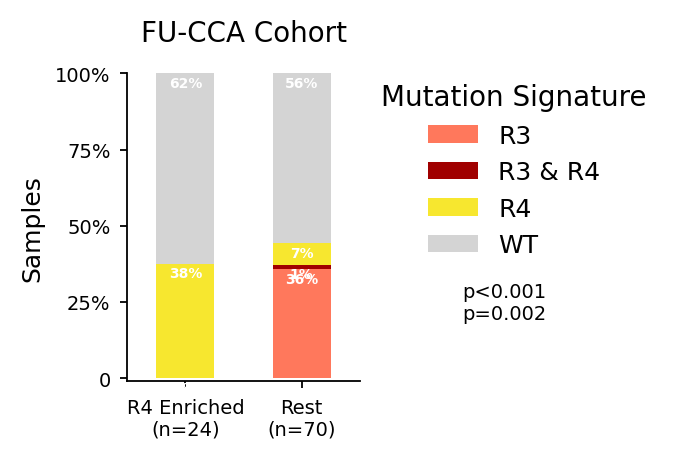

In [281]:
title = 'FU-CCA Cohort'
Utils.split_mutation_profiles(df_R4, R3_muts_l=muts_l, R4_muts_l=R4_muts_l, color_dic=color_dic, title=title, file_name='FU_CCA_R4')

### FU-CCA R4 Survival

In [282]:
ssgsea_df = MyRFunctions.ssgsea(all_exp_df, R4_features_filtered)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [283]:
all_FU_CCA_R4_ssgsea_df = zscore(ssgsea_df)
all_FU_CCA_R4_ssgsea_df.head(10)

,ssGSEA
CCA#2,-1.000193
CCA#4,-1.404213
CCA#9,-0.931623
CCA#11,0.213938
CCA#12,0.260116
CCA#13,0.609697
CCA#14,-0.024429
CCA#15,1.359082
CCA#20,0.066437
CCA#21,1.006204


In [284]:
threshold = np.percentile(all_FU_CCA_R4_ssgsea_df['ssGSEA'], 75)
# threshold=0
print(f'{cluster} Enrichment cut-off:', threshold)
all_FU_CCA_R4_ssgsea_df['R4_ssGSEA'] = (all_FU_CCA_R4_ssgsea_df['ssGSEA'] >= threshold).astype(int)
# all_FU_CCA_R4_ssgsea_df['High_ssGSEA'] = all_FU_CCA_R4_ssgsea_df['R4_ssGSEA'].replace({0: 'Rest', 1: 'R4 Enriched'})

R4 Enrichment cut-off: 0.8131644524077938


In [285]:
surv_df = info_df[['Overall survival(day)', 'Survival(1,dead;0,alive)']].dropna(axis=0, how='all').astype(float)
surv_df['Group'] = 0#'Low ssGSEA'
surv_df.loc[all_FU_CCA_R4_ssgsea_df.loc[surv_df.index, 'R4_ssGSEA'] ==1, 'Group'] = 1#'High ssGSEA'
surv_df

,Overall survival(day),"Survival(1,dead;0,alive)",Group
Patient No.,,,
CCA#2,1216.0,1.0,0
CCA#4,437.0,1.0,0
CCA#11,222.0,1.0,0
CCA#12,391.0,1.0,0
CCA#13,170.0,1.0,0
...,...,...,...
CCA#210,388.0,1.0,0
CCA#211,448.0,1.0,1
CCA#212,276.0,1.0,0


In [286]:
info_filtered_df2, surv_filtered_df = Utils.match_rows_df(info_filtered_df2, surv_df)
surv_filtered_df.shape

(114, 3)

#### Kaplan-Meier

In [287]:
colors_l = ['#a00000','#077f97']
labels = ['Low', ' High']
MyRFunctions.survival_analysis(surv_filtered_df[['Overall survival(day)', 'Survival(1,dead;0,alive)']], surv_filtered_df[['Group']], 'Group', f'FU-CCA Cohort Overal Survival ({cluster} ssGSEA score)', legend_lbls=labels, colors_elms=colors_l, plot_path=os.path.join(io_library.output_dir, f'FU_CCA_Overal_Survival_Plot_{cluster}.pdf'))

0 86
1 28
------


#### Cox Regression

In [288]:
all_clinical_feats_df = pd.concat([all_FU_CCA_R4_ssgsea_df.loc[info_filtered_df2.index, ['ssGSEA']], info_filtered_df2[cont_feats_cols], cat_clinical_feats_df], axis=1)
all_clinical_feats_df = all_clinical_feats_df.rename(columns={'ssGSEA':'R4_ssGSEA'})
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace('-', '_') for col in all_clinical_feats_df.columns})# R cannot take -
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace(' ', '_') for col in all_clinical_feats_df.columns})# R cannot take space
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace('/', '_') for col in all_clinical_feats_df.columns})# R cannot take space
all_clinical_feats_df = all_clinical_feats_df.astype(float)

In [289]:
coxph_mv_df = MyRFunctions.coxph_multivariate(surv_filtered_df, all_clinical_feats_df)
coxph_mv_df

[1] "AIC of cox model:  650.785585643258"
[1] "Proportional Hazards Assumption: "
                                              chisq df           p
R4_ssGSEA                               0.793675778  1 0.372990960
Age                                     0.044848546  1 0.832282766
Tumor_size                              0.112039305  1 0.737834255
Preoperative_CA19_9                     1.693087244  1 0.193194502
Preoperative_CEA                        9.480201740  1 0.002077011
TB_total_bilirubin                      0.464184073  1 0.495675006
Gender_Male                             0.014550826  1 0.903986636
Anatomical_classification_intrahepatic  1.440876599  1 0.229997540
iCCA_classification_Unknown             0.002998867  1 0.956328147
iCCA_classification_large_iBD           2.687879617  1 0.101114288
HBsAg_Negative                          0.063594860  1 0.800901772
HBsAg_Positive                          0.208580060  1 0.647882622
Cholelithiasis_Yes                      0.00534

,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,iCCA_classification_Unknown,1.720352,5.586492,0.477945,3.599475,0.000319,2.189332,14.254988,0.783596,2.657107,0.008928
1,R4_ssGSEA,0.582835,1.791109,0.178738,3.260827,0.001111,1.261768,2.54252,0.232514,0.933156,0.014848
2,Jaundice_Yes,-2.479994,0.083744,0.785409,-3.157585,0.001591,0.017964,0.390385,-4.019367,-0.940622,0.014848
3,TB_total_bilirubin,0.007447,1.007475,0.002646,2.814122,0.004891,1.002263,1.012714,0.002260,0.012634,0.034238
4,Gender_Male,0.652219,1.919796,0.284832,2.289836,0.022031,1.098514,3.355095,0.093958,1.210480,0.123373
5,eccStage_II,-2.510388,0.081237,1.409076,-1.781584,0.074817,0.005133,1.28576,-5.272126,0.251350,0.349146
6,eccStage_IIIC,-2.559019,0.077381,1.507554,-1.697465,0.089609,0.004031,1.48547,-5.513770,0.395731,0.358435
7,iccStage_IA,-2.14964,0.116526,1.561834,-1.376356,0.168711,0.005457,2.488047,-5.210778,0.911498,0.52488
8,eccStage_IIIB,-2.012166,0.133699,1.412436,-1.424607,0.154271,0.008392,2.130075,-4.780490,0.756157,0.52488
9,Preoperative_CA19_9,0.000098,1.000098,0.000094,1.048748,0.294294,0.999915,1.000282,-0.000085,0.000282,0.678981


<Figure size 500x700 with 0 Axes>

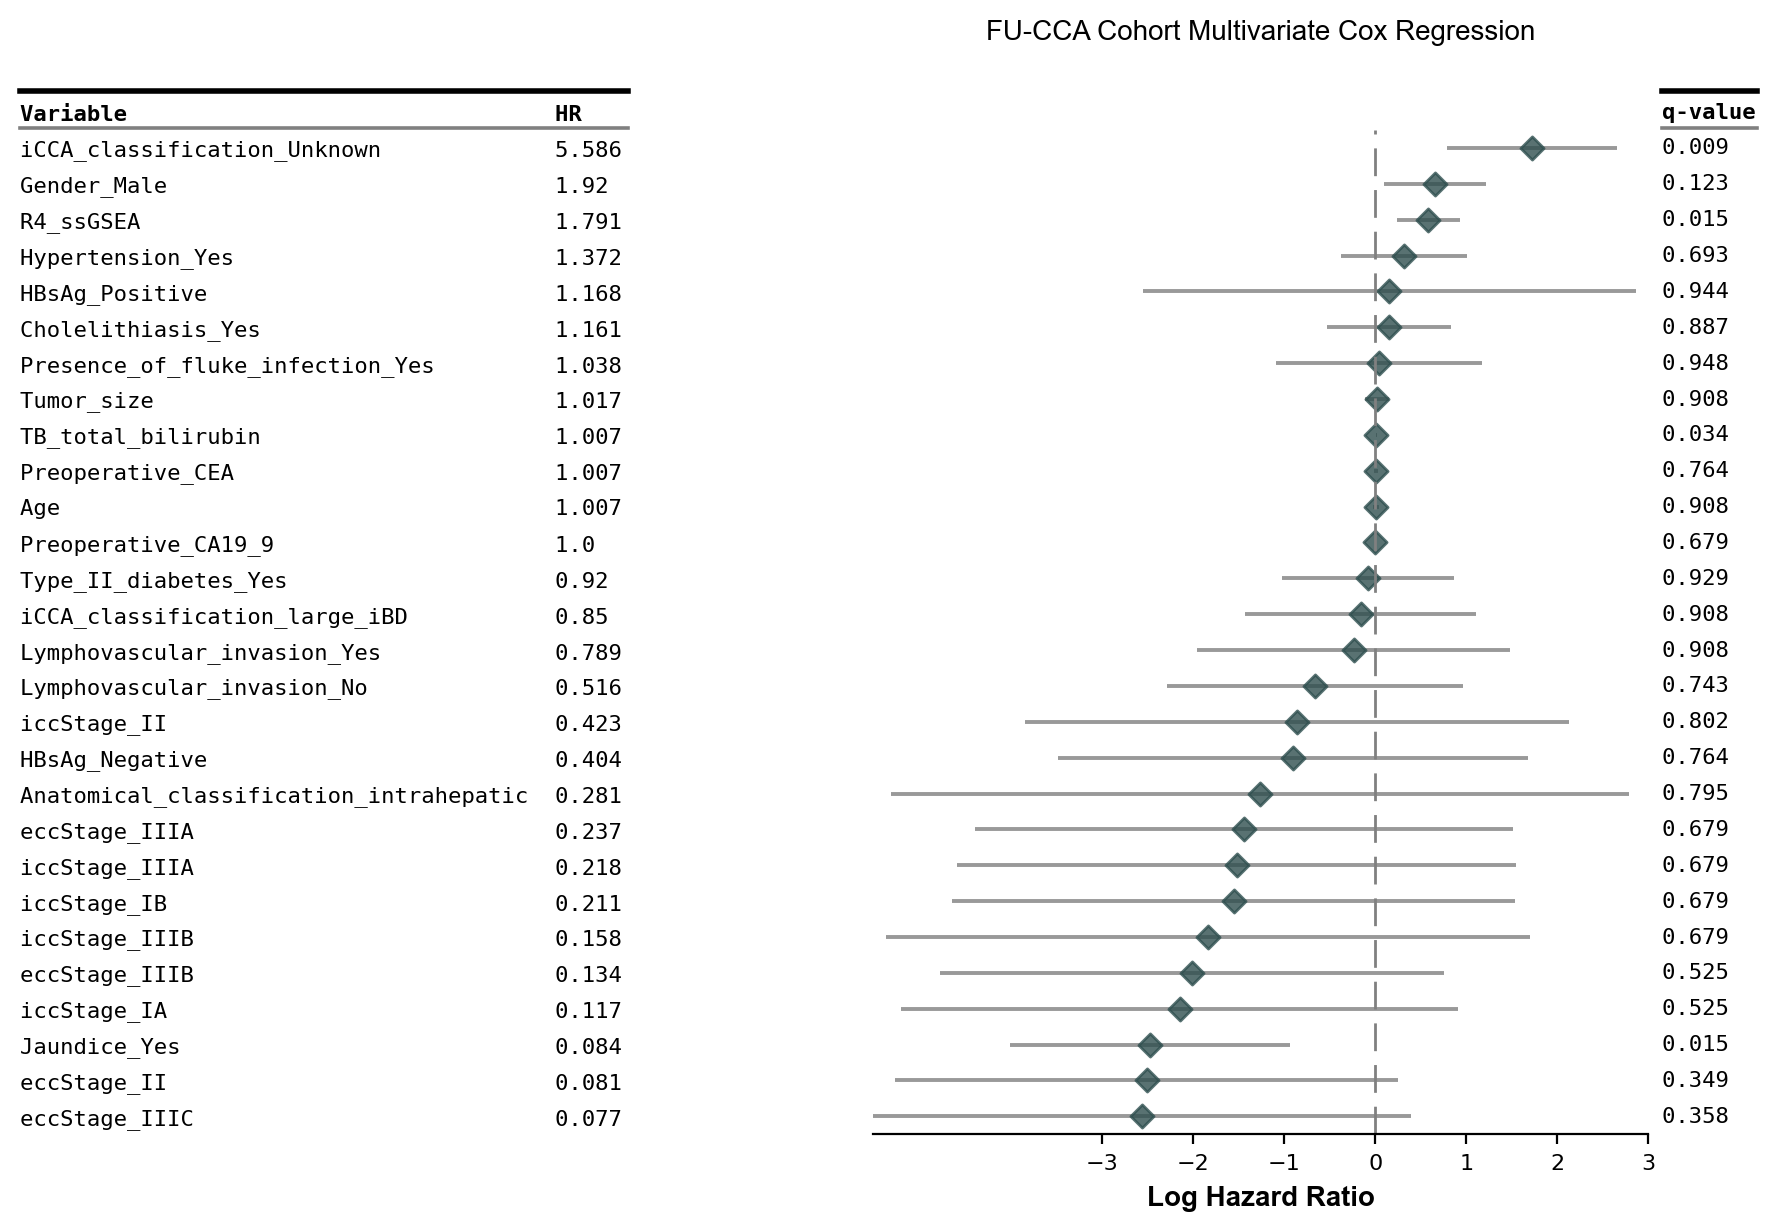

In [290]:
MyVisualization.forest_plot(coxph_mv_df, title='FU-CCA Cohort Multivariate Cox Regression', decimal_precision=3)

In [291]:
coxph_uni_df = MyRFunctions.coxph_multivariate(surv_filtered_df, all_FU_CCA_R4_ssgsea_df.loc[info_filtered_df2.index, ['ssGSEA']])
coxph_uni_df

[1] "AIC of cox model:  663.291731727036"
[1] "Proportional Hazards Assumption: "
           chisq df         p
ssGSEA 0.1889458  1 0.6637955
GLOBAL 0.1889458  1 0.6637955


,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,ssGSEA,0.482429,1.620005,0.120718,3.996342,0.000064,1.278678,2.052445,0.245827,0.719032,0.000064


In [292]:
MyLib.save_csv(coxph_mv_df, 'FU_CCA_cox_mutlivariate_R4_ssGSEA.csv', index=False)


File  patients_analysis/output_files_patients/FU_CCA_cox_mutlivariate_R4_ssGSEA.csv saved, shape: (28, 11)


## TP63 (not in the data)

In [293]:
'TP63' in exp_df.index

False

## Save results

In [294]:
FU_CCA_R3_ssgsea_df

,ssGSEA,High_ssGSEA
CCA#20,-1.704494,Rest
CCA#21,-1.001702,Rest
CCA#22,-1.354439,Rest
CCA#23,-1.171998,Rest
CCA#30,0.404393,Rest
...,...,...
CCA#198,-0.813921,Rest
CCA#206,-0.300601,Rest
CCA#208,-0.912085,Rest
CCA#210,-1.813355,Rest


In [295]:
FU_CCA_R4_ssgsea_df

,ssGSEA,High_ssGSEA
CCA#20,0.190771,Rest
CCA#21,1.134242,R4 Enriched
CCA#22,-0.346277,Rest
CCA#23,1.971387,R4 Enriched
CCA#30,-0.334695,Rest
...,...,...
CCA#198,0.905242,R4 Enriched
CCA#206,0.262883,Rest
CCA#208,0.325318,Rest
CCA#210,-0.089419,Rest


In [296]:
fu_cca_mut_df

,IDH1_MT,IDH2_MT,BAP1_MT,PBRM1_MT,ARID1A_MT,KRAS_MT,SMAD4_MT,FGFR2_MT,mutation_R3,mutation_R4
Patient No.,,,,,,,,,,
CCA#101,0,0,0,0,0,0,0,0,WT,WT
CCA#102,0,0,0,0,0,0,0,0,WT,WT
CCA#103,0,0,0,0,0,1,1,0,WT,MT
CCA#105,0,0,0,0,0,0,0,0,WT,WT
CCA#110,0,0,0,0,0,0,0,0,WT,WT
...,...,...,...,...,...,...,...,...,...,...
CCA#92,0,0,0,0,0,0,1,0,WT,MT
CCA#93,0,0,0,0,0,0,0,0,WT,WT
CCA#94,0,0,0,0,1,0,0,0,WT,WT


In [297]:
d1 = FU_CCA_R3_ssgsea_df[['ssGSEA', 'High_ssGSEA']]
d1 = d1.rename(columns={'ssGSEA':'R3_ssGSEA', 'High_ssGSEA':f'R3_status (thr={round(R3_threshold,3)})'})
d2 = FU_CCA_R4_ssgsea_df[['ssGSEA', 'High_ssGSEA']]
d2 = d2.rename(columns={'ssGSEA':'R4_ssGSEA', 'High_ssGSEA':f'R4_status (thr={round(R4_threshold,3)})'})
# df = pd.concat([d1, d2, fu_cca_mut_df, exp_df.T], axis=1)
# MyLib.save_csv(df, 'FU_CCA_ssGSEA_mutations_RNA.csv')
df = pd.concat([d1, d2, fu_cca_mut_df[['mutation_R3', 'mutation_R4']]], axis=1)
MyLib.save_csv(df, 'FU_CCA_ssGSEA_mutations.csv')


File  patients_analysis/output_files_patients/FU_CCA_ssGSEA_mutations.csv saved, shape: (94, 6)


# FU_CCA dataset - iCCA classification 

In [298]:
FU_CCA_dataset_file = 'Patients_Data/FU-CCA/hep_2023_03_28_xu_hep-22-0042_sdc1.xlsx'
supp = pd.ExcelFile(os.path.join(io_library.input_dir, FU_CCA_dataset_file))

info_df = supp.parse(supp.sheet_names[1])
info_df['Tumor (T) RNA-seq ID'] = info_df['Tumor (T) RNA-seq ID'].apply(lambda x: x.replace('_', '-') if not pd.isna(x) else x)
temp_df = info_df[['Patient No.', 'Tumor (T) RNA-seq ID', 'iCCA classification']].copy()
temp_df['iCCA classification'] = temp_df['iCCA classification'].apply(lambda x:np.nan if x=='Unknown' else x)
temp_df = temp_df.dropna().copy()

ids = dict(zip(temp_df['Tumor (T) RNA-seq ID'], temp_df['Patient No.']))

exp_df = supp.parse(supp.sheet_names[5])
exp_df = exp_df.rename(columns={'RNA-seq ID':'Gene'})
exp_df.set_index('Gene', drop=True, inplace=True)
exp_df = exp_df[temp_df['Tumor (T) RNA-seq ID']]
exp_df = exp_df.rename(columns={col:ids[col] for col in exp_df.columns})
exp_df = exp_df.T.astype(float)
exp_df = exp_df.dropna(axis=1)

In [299]:
rna_HNF1B = exp_df[['HNF1B']]

In [300]:
temp_df.set_index('Patient No.', drop=True, inplace=True)
temp_df['iCCA class'] = temp_df['iCCA classification'].apply(lambda x: 1 if x == 'small iBD' else 0)
df = pd.concat([rna_HNF1B, temp_df[['iCCA class', 'iCCA classification']]], axis=1)
df = df.sort_values(by=['HNF1B'], ascending=False)
print(df.shape)
df.head(10)

(72, 3)


,HNF1B,iCCA class,iCCA classification
CCA#70,83.566572,1,small iBD
CCA#98,69.732399,1,small iBD
CCA#90,68.508424,1,small iBD
CCA#73,59.482620,1,small iBD
CCA#47,49.054285,1,small iBD
CCA#121,48.422540,1,small iBD
CCA#51,48.083103,1,small iBD
CCA#59,47.314013,1,small iBD
CCA#72,46.322311,1,small iBD
CCA#34,45.322151,1,small iBD


ranksum p-value=0.006118840559718804
There is a significant association.


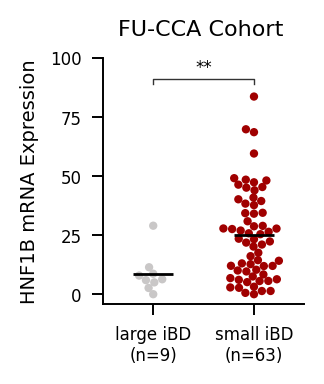

In [301]:
color = {'large iBD': control_color, 'small iBD': '#A00000'}
x = 'iCCA classification'
y = 'HNF1B'
y_label = 'HNF1B mRNA Expression'
title = 'FU-CCA Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum', y_label=y_label,title=title, ylim_top=100, ytick_step=25, label_newline=True, title_fontsize=8, tick_fontsize=6, label_fontsize=7., figure_width=1.3, figure_height=1.6, save_figure=True, file_suffix='_iBD')

# FU-iCCA dataset - CPTAC

Dong, Liangqing, et al. "Proteogenomic characterization identifies clinically relevant subgroups of intrahepatic cholangiocarcinoma." Cancer cell 40.1 (2022): 70-87.
https://www.sciencedirect.com/science/article/pii/S1535610821006590

In [302]:
FU_iCCA_dataset_file = 'Patients_Data/CPTAC-FU_iCCA/1-s2.0-S1535610821006590-mmc2.xlsx'
supp = pd.ExcelFile(os.path.join(io_library.input_dir, FU_iCCA_dataset_file))

info_df = supp.parse(supp.sheet_names[1], skiprows=1, header=0, index_col=0)
info_df = info_df[(info_df['RNA_seq']=='Yes') & (info_df['WES_seq']=='Yes')].copy()
info_df

,Sex,Age,Intrahepatic metastasis,Liver fluke,"HBsAg (1, positive; 0, negative)",Biliary tract stone disease,Tumor_size_diameter (cm),Vascular invasion,Liver cirrhosis,Regional lymph Node metastasis,...,"γ-GT, γ-glutamyltransferase (U/L)",TNM stage,"OS, overall survival (day)",OS_event,Adjuvant therapies,WES_seq,RNA_seq,Proteome,Phosphoproteome,Microbiome
Patient_ID,,,,,,,,,,,,,,,,,,,,,
111,Male,49,No,No,1,No,7.5,Yes,No,No,...,80.0,IIIA,682.0,1.0,TACE,Yes,Yes,No,No,No
113,Male,59,Yes,No,0,No,15.0,Yes,No,Yes,...,40.0,IIIB,183.0,1.0,No treatment,Yes,Yes,No,No,No
115,Male,74,No,No,0,No,4.5,Yes,No,No,...,29.0,IIIB,1806.0,0.0,No treatment,Yes,Yes,Yes,Yes,No
117,Female,64,No,Yes,0,No,4.6,No,No,No,...,27.0,IIIB,808.0,1.0,Chemotherapy,Yes,Yes,Yes,Yes,No
121,Female,71,No,No,0,No,5.2,No,No,No,...,23.0,IB,1317.0,0.0,No treatment,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,Female,65,No,No,0,No,7.5,Yes,No,Yes,...,24.0,IIIB,447.0,0.0,Chemotherapy,Yes,Yes,Yes,Yes,Yes
983,Female,65,No,No,1,No,3.3,No,No,No,...,20.0,IA,330.0,0.0,No treatment,Yes,Yes,Yes,Yes,No
987,Male,63,Yes,No,0,No,7.0,No,No,No,...,47.0,II,427.0,0.0,TACE,Yes,Yes,No,No,No


In [303]:
exp_df = supp.parse(supp.sheet_names[3], skiprows=1, header=0, index_col=0)
exp_df = exp_df.rename(columns={c:int(c.strip()) for c in exp_df.columns})
exp_df = exp_df.loc[:,info_df.index.tolist()]
exp_df.shape

(20173, 249)

In [304]:
mutation = ['IDH1', 'IDH2', 'BAP1', 'PBRM1', 'ARID1A', 'KRAS', 'SMAD4', 'BRAF']
FU_iCCA_mut_df = pd.DataFrame(0, index=info_df.index, columns=mutation)
mut_maf_df = supp.parse(supp.sheet_names[2], skiprows=1, header=0)
mut_maf_df = mut_maf_df[mut_maf_df['Gene'].isin(mutation)]

In [305]:
mut_maf_df.head()

,Sample_ID,Chromosome,Position,Reference,Alteration,Gene,Transcript_ID,HGVSc,HGVSp,Mutation_Type,Variant allele frequency (VAF)
269,117,2,209113113,G,A,IDH1,NM_005896.3,c.394C>T,p.Arg132Cys,missense_variant,0.151
303,121,1,27023684,TCGTCCTTCGCTCAGC,T,ARID1A,NM_006015.4,c.791_805del,p.Ser264_Gln269delins*,stop_gained,0.292
355,123,2,209113113,G,A,IDH1,NM_005896.3,c.394C>T,p.Arg132Cys,missense_variant,0.185
383,125,3,52440887,G,T,BAP1,NM_004656.3,c.617C>A,p.Ala206Asp,missense_variant,0.244
450,131,12,25398284,C,A,KRAS,NM_033360.3,c.35G>T,p.Gly12Val,missense_variant,0.301


In [306]:
gp = mut_maf_df.groupby('Gene')
for gene, df in gp:
    ids = df['Sample_ID'].unique()
    shared_ids = list(set(ids).intersection(info_df.index.values))
    FU_iCCA_mut_df.loc[shared_ids, gene] = 1

In [307]:
fusion_df = supp.parse(supp.sheet_names[8], skiprows=1, header=0, index_col=0)
fusion_df['LeftGene'] = fusion_df['LeftGene'].apply(lambda x: x.strip())
fusion_df['RightGene'] = fusion_df['RightGene'].apply(lambda x: x.strip())
fusion_df = fusion_df[(fusion_df['LeftGene']=='FGFR2') | (fusion_df['RightGene']=='FGFR2')]

FU_iCCA_mut_df['FGFR2'] = 0
FU_iCCA_mut_df.loc[fusion_df.index, 'FGFR2'] = 1

In [308]:
muts_l =  ['IDH1_MT', 'IDH2_MT', 'BAP1_MT',  'FGFR2_MT']
FU_iCCA_mut_df['mutation_R3'] = (FU_iCCA_mut_df['IDH1'] | FU_iCCA_mut_df['IDH2'] | FU_iCCA_mut_df['BAP1'] | FU_iCCA_mut_df['FGFR2']).astype(int)
FU_iCCA_mut_df['mutation_R3'] = FU_iCCA_mut_df['mutation_R3'].replace({0: 'WT', 1: 'MT'})


R4_muts_l=['KRAS_MT', 'SMAD4_MT', 'BRAF_MT' ]
FU_iCCA_mut_df['mutation_R4'] = (FU_iCCA_mut_df['KRAS'] | FU_iCCA_mut_df['SMAD4'] | FU_iCCA_mut_df['BRAF']).astype(int)
FU_iCCA_mut_df['mutation_R4'] = FU_iCCA_mut_df['mutation_R4'].replace({0: 'WT', 1: 'MT'})

FU_iCCA_mut_df = FU_iCCA_mut_df.rename(columns={c:c+'_MT' for c in ['IDH1', 'IDH2', 'BAP1',  'FGFR2', 'ARID1A', 'PBRM1','KRAS', 'SMAD4', 'BRAF']})
FU_iCCA_mut_df.head(10)

,IDH1_MT,IDH2_MT,BAP1_MT,PBRM1_MT,ARID1A_MT,KRAS_MT,SMAD4_MT,BRAF_MT,FGFR2_MT,mutation_R3,mutation_R4
Patient_ID,,,,,,,,,,,
111,0,0,0,0,0,0,0,0,0,WT,WT
113,0,0,0,0,0,0,0,0,1,MT,WT
115,0,0,0,0,0,0,0,0,0,WT,WT
117,1,0,0,0,0,0,0,0,0,MT,WT
121,0,0,0,0,1,0,0,0,0,WT,WT
123,1,0,0,0,0,0,0,0,0,MT,WT
125,0,0,1,0,0,1,0,0,0,MT,MT
127,0,0,0,0,0,0,0,0,0,WT,WT
131,0,0,0,0,0,1,0,0,0,WT,MT


## ssGSEA for R3 Signature

In [309]:
R3_features_filtered = sorted(set(R3_features).intersection(set(exp_df.index)))
print('Shared features:', len(R3_features_filtered))

Shared features: 48


In [310]:
ssgsea_df = MyRFunctions.ssgsea(exp_df, R3_features_filtered)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [311]:
FU_iCCA_R3_ssgsea_df = zscore(ssgsea_df)
FU_iCCA_R3_ssgsea_df.head(10)

,ssGSEA
111,-1.319180
113,0.039561
115,-0.630997
117,0.603531
121,0.848034
123,0.486694
125,-1.643681
127,-2.552286
131,-2.200880
133,-1.757480


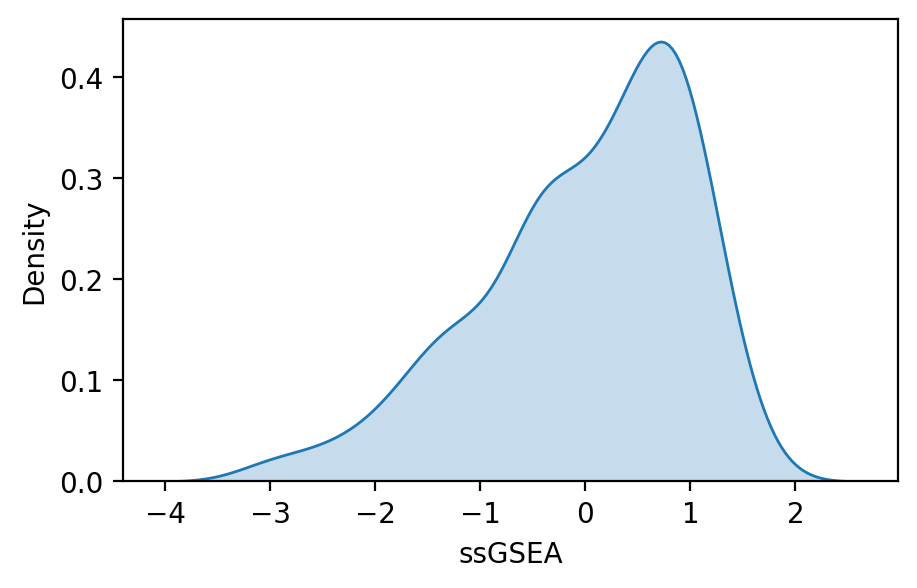

In [312]:
MyVisualization.plot_distribution(FU_iCCA_R3_ssgsea_df['ssGSEA'])

In [313]:
R3_threshold = np.percentile(FU_iCCA_R3_ssgsea_df['ssGSEA'], 75)
print('Enrichment cut-off:', R3_threshold) 
FU_iCCA_R3_ssgsea_df['High_ssGSEA'] = (FU_iCCA_R3_ssgsea_df['ssGSEA'] > R3_threshold).astype(int)
FU_iCCA_R3_ssgsea_df['High_ssGSEA'] = FU_iCCA_R3_ssgsea_df['High_ssGSEA'].replace({0: 'Rest', 1: 'R3 Enriched'})
FU_iCCA_R3_ssgsea_df.head(10)

Enrichment cut-off: 0.7982507604469877


,ssGSEA,High_ssGSEA
111,-1.319180,Rest
113,0.039561,Rest
115,-0.630997,Rest
117,0.603531,Rest
121,0.848034,R3 Enriched
123,0.486694,Rest
125,-1.643681,Rest
127,-2.552286,Rest
131,-2.200880,Rest
133,-1.757480,Rest


In [314]:
df = pd.concat([FU_iCCA_R3_ssgsea_df, FU_iCCA_mut_df, exp_df.T], axis=1)
# MyLib.save_csv(df, 'FU_iCCA_R3_ssGSEA_mutations_RNA.csv')
df = df.sort_values(by=['ssGSEA'], ascending=False)

## R3 Mutation Signature comparison

Mutations: ['IDH1_MT', 'IDH2_MT', 'BAP1_MT', 'FGFR2_MT']
ranksum p-value=1.9393142909117975e-16
There is a significant association.


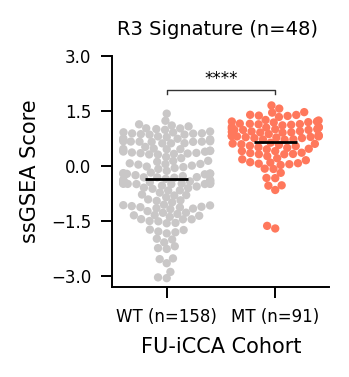

In [315]:
color = {'WT': control_color, 'MT': R3_color}
x = 'mutation_R3'
y = 'ssGSEA'
y_label = 'ssGSEA Score'
x_label = 'FU-iCCA Cohort'
title = f'R3 Signature (n={len(R3_features_filtered)})'
print('Mutations:', muts_l)
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, y_label=y_label, x_label=x_label, title=title, label_newline=False,title_fontsize=7, tick_fontsize=6, label_fontsize=7.5, ylim_top=3., ytick_step=1.5, figure_width=1.4, figure_height=1.5, test='ranksum', save_figure=True)


Mutation_Signature  R3  R3 & R4  R4   WT
High_ssGSEA                             
R3 Enriched         40        4   1   17
Rest                44        3  39  101
-------------------
High_ssGSEA         R3 Enriched  Rest
Mutation_Signature                   
R4                            5    42
WT                           57   145
Odds Ratio: 0.3028404344193818
P-value: 0.013979603603211077
There is a significant association between R4 and WT
WT wrt R4, p-value:
{('R4', 'WT'): 0.013979603603211077}
-------------------
High_ssGSEA         R3 Enriched  Rest
Mutation_Signature                   
R3                           44    47
WT                           18   140
Odds Ratio: 7.281323877068558
P-value: 2.340677223380552e-10
There is a significant association between R3 and WT
WT wrt R3, p-value:
{('R3', 'WT'): 2.340677223380552e-10}
-------------------
p-value= [2.340677223380552e-10, 0.013979603603211077]


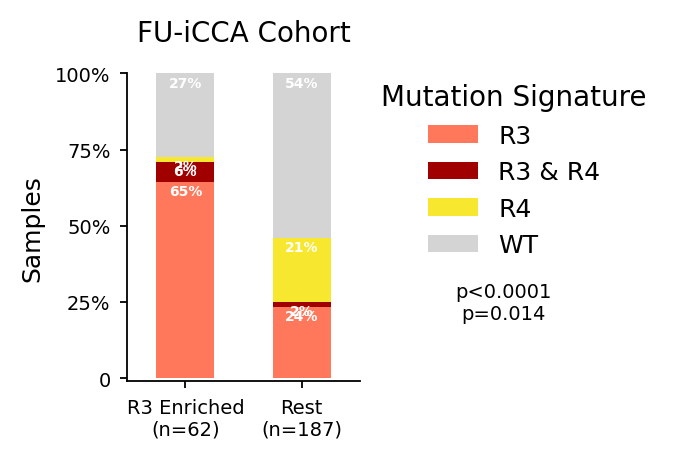

In [316]:
title = 'FU-iCCA Cohort'
Utils.split_mutation_profiles(df, R3_muts_l=muts_l, R4_muts_l=R4_muts_l, color_dic=color_dic, title=title, file_name='FU_iCCA_R3')

## HNF1B - RNA

ranksum p-value=2.2454927989959007e-19
There is a significant association.


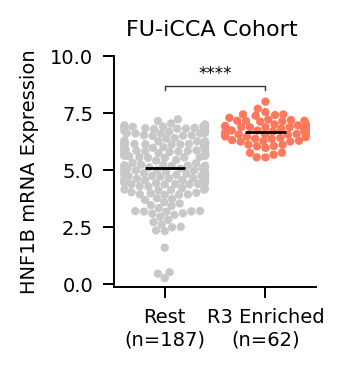

In [317]:
color = {'Rest': control_color, 'R3 Enriched': R3_color}
x = 'High_ssGSEA'
y = 'HNF1B'
y_label = 'HNF1B mRNA Expression'
title = 'FU-iCCA Cohort'
# title = f'Bipotential R3 Signature (n={len(R3_features_filtered)})'x_label=x_label,
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum',  y_label=y_label, title=title, label_newline=True, title_fontsize=8,title_height=1.0, ylim_top=10, ytick_step=2.5, tick_fontsize=7, label_fontsize=7.,figure_width=1.3, figure_height=1.5, save_figure=True)


## CSGALNACT1 - RNA

ranksum p-value=3.5086702305247772e-12
There is a significant association.


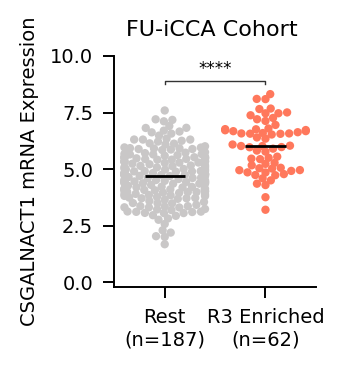

In [318]:
color = {'Rest': control_color, 'R3 Enriched': R3_color}
x = 'High_ssGSEA'
y = 'CSGALNACT1'
y_label = 'CSGALNACT1 mRNA Expression'
title = 'FU-iCCA Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum',  y_label=y_label, title=title, label_newline=True, title_fontsize=8,title_height=1.0,ylim_bottom=-0.2, ylim_top=10, ytick_step=2.5, tick_fontsize=7, label_fontsize=7.,figure_width=1.3, figure_height=1.5, save_figure=True)

## SULT1A1 - RNA

ranksum p-value=1.1172478791494769e-07
There is a significant association.


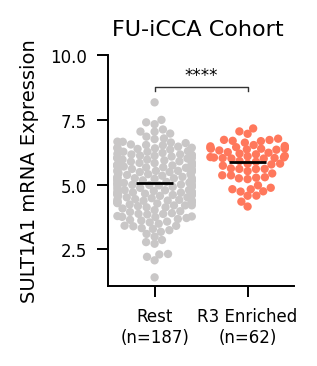

In [319]:
color = {'Rest': control_color, 'R3 Enriched': R3_color}
x = 'High_ssGSEA'
y = 'SULT1A1'
y_label = 'SULT1A1 mRNA Expression'
title = 'FU-iCCA Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=y, color_dic=color, test='ranksum', y_label=y_label, title=title, label_newline=True, title_fontsize=8, ylim_top=10, ytick_step=2.5, title_height=1.0, tick_fontsize=6, label_fontsize=7.,figure_width=1.2, figure_height=1.5, save_figure=True)

## R3 Survival Analysis

In [320]:
cluster = 'R3'
FU_iCCA_R3_ssgsea_df['R3_ssGSEA'] = FU_iCCA_R3_ssgsea_df['High_ssGSEA'].replace({'R3 Enriched':1, 'Rest': 0})
surv_df = info_df[['OS, overall survival (day)', 'OS_event']].dropna(axis=0, how='all').astype(float)
surv_df['Group'] = 0#'Low ssGSEA'
surv_df.loc[FU_iCCA_R3_ssgsea_df.loc[surv_df.index, 'R3_ssGSEA'] ==1, 'Group'] = 1#'High ssGSEA'
surv_df

,"OS, overall survival (day)",OS_event,Group
Patient_ID,,,
111,682.0,1.0,0
113,183.0,1.0,0
115,1806.0,0.0,0
117,808.0,1.0,0
121,1317.0,0.0,1
...,...,...,...
981,447.0,0.0,0
983,330.0,0.0,0
987,427.0,0.0,0


In [321]:
colors_l = ['#a00000','#077f97']
labels = ['Low', ' High']
MyRFunctions.survival_analysis(surv_df[['OS, overall survival (day)', 'OS_event']], surv_df[['Group']], 'Group', f'FU-iCCA Cohort Overal Survival ({cluster} signature ssGSEA score)', legend_lbls=labels, colors_elms=colors_l, plot_path=os.path.join(io_library.output_dir, f'FU_iCCA_Overal_Survival_Plot_{cluster}.pdf'))

0 178
1 60
------


### Cox Regression

In [322]:
info_filtered_df = info_df.loc[surv_df.index]
info_filtered_df.shape

(238, 28)

In [323]:
info_filtered_df = info_filtered_df.rename(columns={'HBsAg  (1, positive; 0, negative)':'HBsAg', 'Tumor_size_diameter (cm)':'Tumor_size_diameter', 'TB: total bilirubin (μmol/L)':'TB total bilirubin', 'CA19-9, carbohydrate antigen 19-9 (U/mL)':'CA19-9', 'CEA, carcinoembryonic antigen (μg/L)':'CEA carcinoembryonic antigen'})

In [324]:
cat_feats_cols = ['Sex', 'Intrahepatic metastasis', 'Liver fluke', 'Biliary tract stone disease', 'Vascular invasion', 'Liver cirrhosis','Regional lymph Node metastasis','Perineural invasion', 'TNM stage','Adjuvant therapies']#'Distal metastasis',  
cont_feats_cols = ['HBsAg', 'Age', 'Tumor_size_diameter', 'TB total bilirubin', 'CA19-9', 'CEA carcinoembryonic antigen']

In [325]:
cat_clinical_feats_df = Utils.create_onehot_encoding_columns(info_filtered_df, cat_feats_cols)

Sex
Reference level: Sex_Female
------
Intrahepatic metastasis
Reference level: Intrahepatic metastasis_No
------
Liver fluke
Reference level: Liver fluke_No
------
Biliary tract stone disease
Reference level: Biliary tract stone disease_No
------
Vascular invasion
Reference level: Vascular invasion_No
------
Liver cirrhosis
Reference level: Liver cirrhosis_No
------
Regional lymph Node metastasis
Reference level: Regional lymph Node metastasis_No
------
Perineural invasion
Reference level: Perineural invasion_No
------
TNM stage
Reference level: TNM stage_IA
------
Adjuvant therapies
Reference level: Adjuvant therapies_Chemotherapy
------


In [326]:
# all_clinical_feats_df = pd.concat([FU_iCCA_R3_ssgsea_df.loc[info_filtered_df.index, ['ssGSEA']], info_filtered_df[cont_feats_cols], info_filtered_df[cat_feats_cols]], axis=1)
all_clinical_feats_df = pd.concat([FU_iCCA_R3_ssgsea_df.loc[info_filtered_df.index, ['ssGSEA']], info_filtered_df[cont_feats_cols], cat_clinical_feats_df], axis=1)
all_clinical_feats_df = all_clinical_feats_df.rename(columns={'ssGSEA': 'R3_ssGSEA'})
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace('-', '_') for col in all_clinical_feats_df.columns})# R cannot take -
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace(' ', '_') for col in all_clinical_feats_df.columns})# R cannot take space
# all_clinical_feats_df = all_clinical_feats_df.astype(float)
all_clinical_feats_df.shape

(238, 22)

In [327]:
MyRFunctions.find_collinearity(all_clinical_feats_df.drop(['HBsAg'], axis=1), all_clinical_feats_df[['HBsAg']])

Model :
HBsAg ~ R3_ssGSEA + Age + Tumor_size_diameter + TB_total_bilirubin + 
    CA19_9 + CEA_carcinoembryonic_antigen + Sex_Male + Intrahepatic_metastasis_Yes + 
    Liver_fluke_Yes + Biliary_tract_stone_disease_Yes + Vascular_invasion_Yes + 
    Liver_cirrhosis_Yes + Regional_lymph_Node_metastasis_Yes + 
    Perineural_invasion_Yes + TNM_stage_IB + TNM_stage_II + TNM_stage_IIIA + 
    TNM_stage_IIIB + TNM_stage_IV + Adjuvant_therapies_No_treatment + 
    Adjuvant_therapies_TACE



In [328]:
# MyLib.save_csv(surv_df[['OS, overall survival (day)', 'OS_event']], 'survival.csv')
# MyLib.save_csv(all_clinical_feats_df, 'all_clinical_feats_df.csv')

In [329]:
coxph_mv_df = MyRFunctions.coxph_multivariate(surv_df[['OS, overall survival (day)', 'OS_event']], all_clinical_feats_df)
coxph_mv_df

[1] "AIC of cox model:  876.765855334238"
[1] "Proportional Hazards Assumption: "
                                          chisq df          p
R3_ssGSEA                          4.073358e-01  1 0.52332487
HBsAg                              1.498695e-01  1 0.69866013
Age                                2.768905e+00  1 0.09611189
Tumor_size_diameter                3.583227e+00  1 0.05836568
TB_total_bilirubin                 3.028917e-04  1 0.98611449
CA19_9                             5.121035e-02  1 0.82097040
CEA_carcinoembryonic_antigen       2.326403e-02  1 0.87877247
Sex_Male                           1.152171e-02  1 0.91451986
Intrahepatic_metastasis_Yes        1.082871e+00  1 0.29805623
Liver_fluke_Yes                    1.995188e+00  1 0.15779946
Biliary_tract_stone_disease_Yes    2.615538e+00  1 0.10582163
Vascular_invasion_Yes              2.328279e-01  1 0.62943487
Liver_cirrhosis_Yes                6.685061e-01  1 0.41357293
Regional_lymph_Node_metastasis_Yes 2.664267e+00  1

,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,Regional_lymph_Node_metastasis_Yes,1.288535,3.627467,0.399959,3.221664,0.001274,1.656371,7.944186,0.504629,2.072440,0.028039
1,R3_ssGSEA,-0.339289,0.712277,0.115768,-2.930767,0.003381,0.567684,0.893698,-0.566190,-0.112388,0.037194
2,TNM_stage_IIIA,1.874748,6.519177,0.672525,2.787626,0.00531,1.744771,24.358305,0.556623,3.192873,0.038937
3,Liver_fluke_Yes,0.906867,2.476552,0.454863,1.993716,0.046183,1.015471,6.039864,0.015353,1.798381,0.203205
4,Biliary_tract_stone_disease_Yes,1.059183,2.884015,0.513978,2.060755,0.039326,1.05317,7.897626,0.051804,2.066562,0.203205
5,TNM_stage_IV,1.150495,3.159757,0.644713,1.784509,0.074341,0.893045,11.179801,-0.113118,2.414109,0.204438
6,Intrahepatic_metastasis_Yes,0.479899,1.615911,0.266204,1.802751,0.071427,0.959013,2.722766,-0.041851,1.001648,0.204438
7,TB_total_bilirubin,0.007469,1.007497,0.00413,1.808513,0.070527,0.999375,1.015686,-0.000626,0.015564,0.204438
8,CA19_9,0.000086,1.000086,0.000051,1.686271,0.091744,0.999986,1.000185,-0.000014,0.000185,0.224262
9,TNM_stage_II,0.677307,1.96857,0.509826,1.328507,0.184011,0.724747,5.347062,-0.321933,1.676547,0.404823


<Figure size 500x600 with 0 Axes>

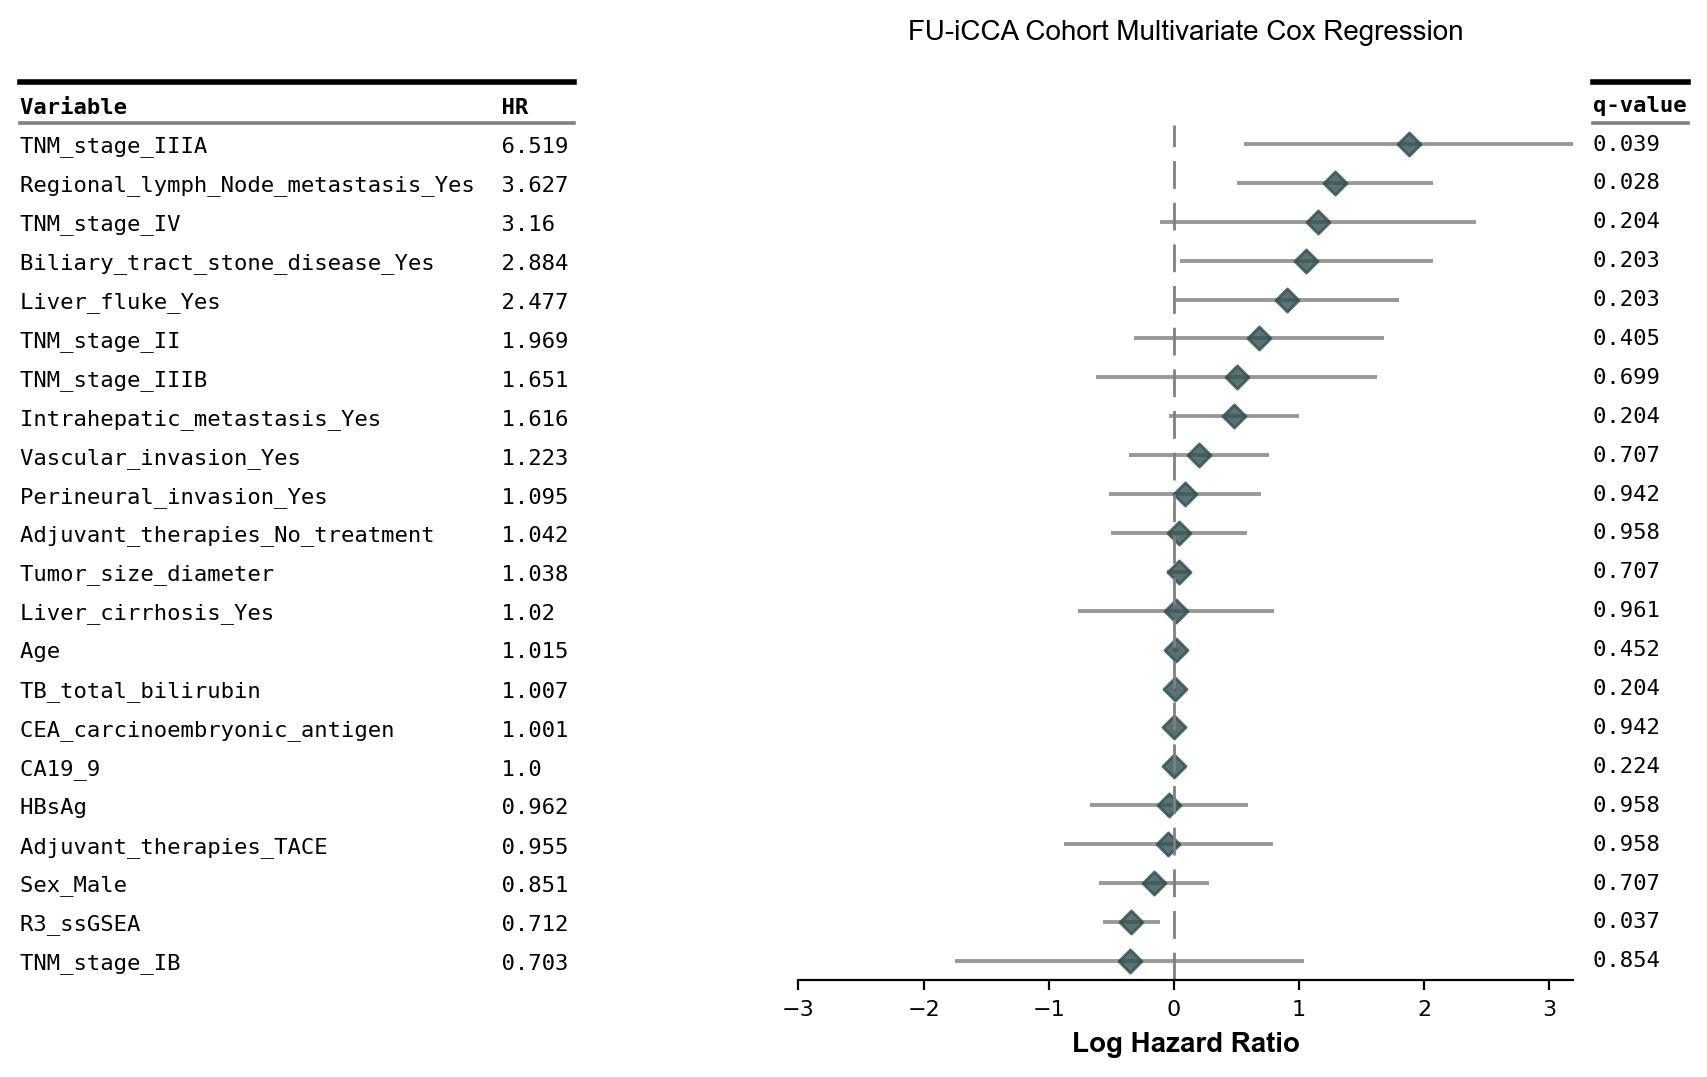

In [330]:
MyVisualization.forest_plot(coxph_mv_df, title='FU-iCCA Cohort Multivariate Cox Regression', figure_width=5, figure_height=6, tick_fontsize=8)

Univariate

In [331]:
coxph_uni_df = MyRFunctions.coxph_multivariate(surv_df[['OS, overall survival (day)', 'OS_event']], FU_iCCA_R3_ssgsea_df.loc[info_filtered_df.index, ['R3_ssGSEA']])
coxph_uni_df

[1] "AIC of cox model:  934.148682956092"
[1] "Proportional Hazards Assumption: "
             chisq df         p
R3_ssGSEA 1.538044  1 0.2149092
GLOBAL    1.538044  1 0.2149092


,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,R3_ssGSEA,-0.826192,0.437713,0.28191,-2.930693,0.003382,0.251899,0.760592,-1.378726,-0.273658,0.003382


In [332]:
MyLib.save_csv(coxph_mv_df, 'FU_iCCA_cox_mutlivariate_R3_ssGSEA.csv', index=False)


File  patients_analysis/output_files_patients/FU_iCCA_cox_mutlivariate_R3_ssGSEA.csv saved, shape: (22, 11)


## ssGSEA for R4 Signature

In [333]:
cluster = 'R4'
R4_features_filtered = sorted(set(R4_features).intersection(set(exp_df.index)))
print('Shared features:', len(R4_features_filtered))

Shared features: 46


In [334]:
ssgsea_df = MyRFunctions.ssgsea(exp_df, R4_features_filtered)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [335]:
FU_iCCA_R4_ssgsea_df = zscore(ssgsea_df)
FU_iCCA_R4_ssgsea_df.head(10)

,ssGSEA
111,-1.516126
113,0.796358
115,0.265844
117,-1.586506
121,0.370129
123,-0.315653
125,-0.681380
127,-0.263970
131,0.227362
133,-1.456587


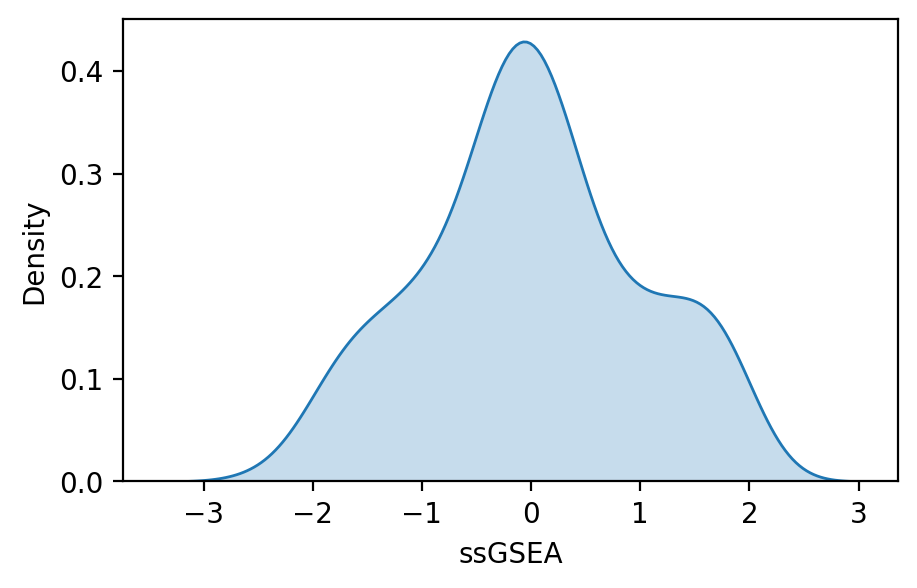

In [336]:
MyVisualization.plot_distribution(FU_iCCA_R4_ssgsea_df['ssGSEA'])

In [337]:
R4_threshold = np.percentile(FU_iCCA_R4_ssgsea_df['ssGSEA'], 75)
print('Enrichment cut-off:', R4_threshold) 
FU_iCCA_R4_ssgsea_df['High_ssGSEA'] = (FU_iCCA_R4_ssgsea_df['ssGSEA'] > R4_threshold).astype(int)
FU_iCCA_R4_ssgsea_df['High_ssGSEA'] = FU_iCCA_R4_ssgsea_df['High_ssGSEA'].replace({0: 'Rest', 1: 'R4 Enriched'})
FU_iCCA_R4_ssgsea_df.head(10)

Enrichment cut-off: 0.6252288902391249


,ssGSEA,High_ssGSEA
111,-1.516126,Rest
113,0.796358,R4 Enriched
115,0.265844,Rest
117,-1.586506,Rest
121,0.370129,Rest
123,-0.315653,Rest
125,-0.681380,Rest
127,-0.263970,Rest
131,0.227362,Rest
133,-1.456587,Rest


In [338]:
df_R4 = pd.concat([FU_iCCA_R4_ssgsea_df, FU_iCCA_mut_df, exp_df.T], axis=1)
# MyLib.save_csv(df, 'FU_CCA_R3_ssGSEA_mutations_RNA.csv')
df_R4 = df_R4.sort_values(by=['ssGSEA'], ascending=False)

## R4 Mutation Signature comparison

Mutations: ['KRAS_MT', 'SMAD4_MT', 'BRAF_MT']
ranksum p-value=2.1136295974848662e-13
There is a significant association.


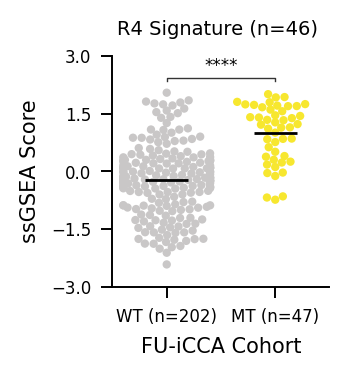

In [339]:
color = {'WT': control_color, 'MT': R4_color}
x = 'mutation_R4'
y = 'ssGSEA'
y_label = 'ssGSEA Score'
x_label = 'FU-iCCA Cohort'
title = f'R4 Signature (n={len(R4_features_filtered)})'
print('Mutations:', R4_muts_l)
Utils.compare_visualize_cat_features(df_R4, x=x, y=y, color_dic=color, y_label=y_label, x_label=x_label, title=title,
                                     label_newline=False, title_fontsize=7, tick_fontsize=6, label_fontsize=7.5,
                                     ylim_top=3., ylim_bottom=-3, ytick_step=1.5, figure_width=1.4, figure_height=1.5,
                                     test='ranksum', save_figure=True)

Mutation_Signature  R3  R3 & R4  R4  WT
High_ssGSEA                            
R4 Enriched          4        2  30  26
Rest                80        5  10  92
-------------------
High_ssGSEA         R4 Enriched  Rest
Mutation_Signature                   
R4                           32    15
WT                           30   172
Odds Ratio: 12.231111111111112
P-value: 1.6087560040043135e-12
There is a significant association between R4 and WT
WT wrt R4, p-value:
{('R4', 'WT'): 1.6087560040043135e-12}
-------------------
High_ssGSEA         R4 Enriched  Rest
Mutation_Signature                   
R3                            6    85
WT                           56   102
Odds Ratio: 0.12857142857142856
P-value: 1.1258430825509619e-07
There is a significant association between R3 and WT
WT wrt R3, p-value:
{('R3', 'WT'): 1.1258430825509619e-07}
-------------------
p-value= [1.1258430825509619e-07, 1.6087560040043135e-12]


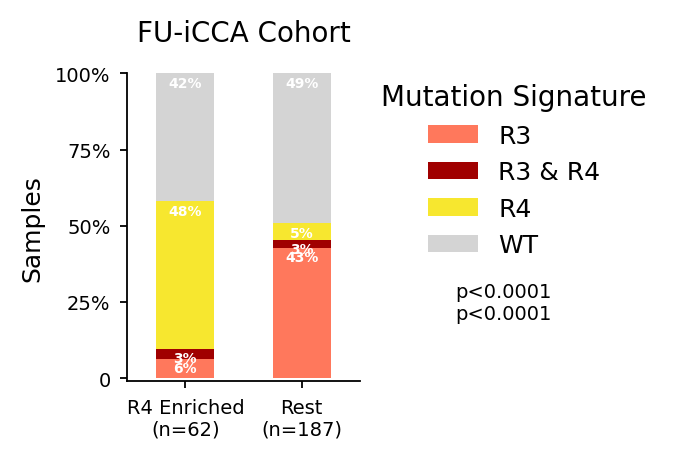

In [340]:
title = 'FU-iCCA Cohort'
Utils.split_mutation_profiles(df_R4, R3_muts_l=muts_l, R4_muts_l=R4_muts_l, color_dic=color_dic, title=title, file_name='FU_iCCA_R4')

## R4 Survival Analysis

In [341]:
FU_iCCA_R4_ssgsea_df['R4_ssGSEA'] = FU_iCCA_R4_ssgsea_df['High_ssGSEA'].replace({'R4 Enriched':1, 'Rest': 0})
surv_df = info_df[['OS, overall survival (day)', 'OS_event']].dropna(axis=0, how='all').astype(float)
surv_df['Group'] = 0#'Low ssGSEA'
surv_df.loc[FU_iCCA_R4_ssgsea_df.loc[surv_df.index, 'R4_ssGSEA'] ==1, 'Group'] = 1#'High ssGSEA'
surv_df

,"OS, overall survival (day)",OS_event,Group
Patient_ID,,,
111,682.0,1.0,0
113,183.0,1.0,1
115,1806.0,0.0,0
117,808.0,1.0,0
121,1317.0,0.0,0
...,...,...,...
981,447.0,0.0,0
983,330.0,0.0,0
987,427.0,0.0,0


In [342]:
colors_l = ['#a00000','#077f97']
labels = ['Low', ' High']
MyRFunctions.survival_analysis(surv_df[['OS, overall survival (day)', 'OS_event']], surv_df[['Group']], 'Group', f'FU-iCCA Cohort Overal Survival ({cluster} signature ssGSEA score)', legend_lbls=labels, colors_elms=colors_l, plot_path=os.path.join(io_library.output_dir, f'FU_iCCA_Overal_Survival_Plot_{cluster}.pdf'))

0 182
1 56
------


#### Cox Regression

In [343]:
all_clinical_feats_df = pd.concat([FU_iCCA_R4_ssgsea_df.loc[info_filtered_df.index, ['ssGSEA']], info_filtered_df[cont_feats_cols], cat_clinical_feats_df], axis=1)
all_clinical_feats_df = all_clinical_feats_df.rename(columns={'ssGSEA': 'R4_ssGSEA'})
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace('-', '_') for col in all_clinical_feats_df.columns})# R cannot take -
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace(' ', '_') for col in all_clinical_feats_df.columns})# R cannot take space
all_clinical_feats_df = all_clinical_feats_df.astype(float)
all_clinical_feats_df.shape

(238, 22)

In [344]:
all_clinical_feats_df

,R4_ssGSEA,HBsAg,Age,Tumor_size_diameter,TB_total_bilirubin,CA19_9,CEA_carcinoembryonic_antigen,Sex_Male,Intrahepatic_metastasis_Yes,Liver_fluke_Yes,...,Liver_cirrhosis_Yes,Regional_lymph_Node_metastasis_Yes,Perineural_invasion_Yes,TNM_stage_IB,TNM_stage_II,TNM_stage_IIIA,TNM_stage_IIIB,TNM_stage_IV,Adjuvant_therapies_No_treatment,Adjuvant_therapies_TACE
Patient_ID,,,,,,,,,,,,,,,,,,,,,
111,-1.516126,1.0,49.0,7.5,8.4,25.2,2.5,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
113,0.796358,0.0,59.0,15.0,9.2,35.0,2.8,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
115,0.265844,0.0,74.0,4.5,7.9,8.2,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
117,-1.586506,0.0,64.0,4.6,14.1,7.9,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
121,0.370129,0.0,71.0,5.2,8.6,24.9,1.4,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,-0.437273,0.0,65.0,7.5,16.2,0.8,2.6,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
983,0.199961,1.0,65.0,3.3,14.6,28.3,2.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
987,-1.213917,0.0,63.0,7.0,9.3,249.0,3.6,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [345]:
coxph_mv_df = MyRFunctions.coxph_multivariate(surv_df, all_clinical_feats_df)
coxph_mv_df

[1] "AIC of cox model:  883.900730976694"
[1] "Proportional Hazards Assumption: "
                                          chisq df           p
R4_ssGSEA                          2.124368e+00  1 0.144972546
HBsAg                              1.497883e-01  1 0.698737718
Age                                2.384108e+00  1 0.122574865
Tumor_size_diameter                3.299235e+00  1 0.069312145
TB_total_bilirubin                 5.555600e-02  1 0.813662977
CA19_9                             1.247996e-02  1 0.911050369
CEA_carcinoembryonic_antigen       4.502564e-02  1 0.831956890
Sex_Male                           4.996577e-04  1 0.982166353
Intrahepatic_metastasis_Yes        7.505341e-01  1 0.386307184
Liver_fluke_Yes                    1.893091e+00  1 0.168853668
Biliary_tract_stone_disease_Yes    3.315794e+00  1 0.068617161
Vascular_invasion_Yes              1.891851e-01  1 0.663595682
Liver_cirrhosis_Yes                8.777044e-01  1 0.348831189
Regional_lymph_Node_metastasis_Yes 3

,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,TNM_stage_IIIA,2.431573,11.376766,0.64595,3.764338,0.000167,3.207638,40.350814,1.165535,3.697612,0.003674
1,Regional_lymph_Node_metastasis_Yes,1.382637,3.985398,0.399024,3.465046,0.00053,1.823147,8.712076,0.600564,2.164710,0.005832
2,TNM_stage_IV,1.505594,4.506831,0.641127,2.348357,0.018856,1.282754,15.834311,0.249009,2.762179,0.13828
3,Biliary_tract_stone_disease_Yes,1.089648,2.973226,0.514782,2.116718,0.034284,1.084039,8.154754,0.080694,2.098601,0.188561
4,TNM_stage_II,0.946574,2.576866,0.506052,1.870506,0.061414,0.955739,6.947754,-0.045270,1.938418,0.27022
5,TB_total_bilirubin,0.007082,1.007107,0.004322,1.638585,0.1013,0.998612,1.015674,-0.001389,0.015553,0.323956
6,Liver_fluke_Yes,0.752883,2.123111,0.461858,1.630116,0.103077,0.858694,5.249371,-0.152343,1.658108,0.323956
7,Intrahepatic_metastasis_Yes,0.409653,1.506295,0.262191,1.562424,0.118188,0.901017,2.518183,-0.104231,0.923538,0.325017
8,Age,0.017709,1.017867,0.012283,1.441773,0.149366,0.993655,1.042668,-0.006365,0.041783,0.33939
9,CA19_9,0.000076,1.000076,0.000053,1.424616,0.154268,0.999971,1.000181,-0.000029,0.000181,0.33939


<Figure size 500x600 with 0 Axes>

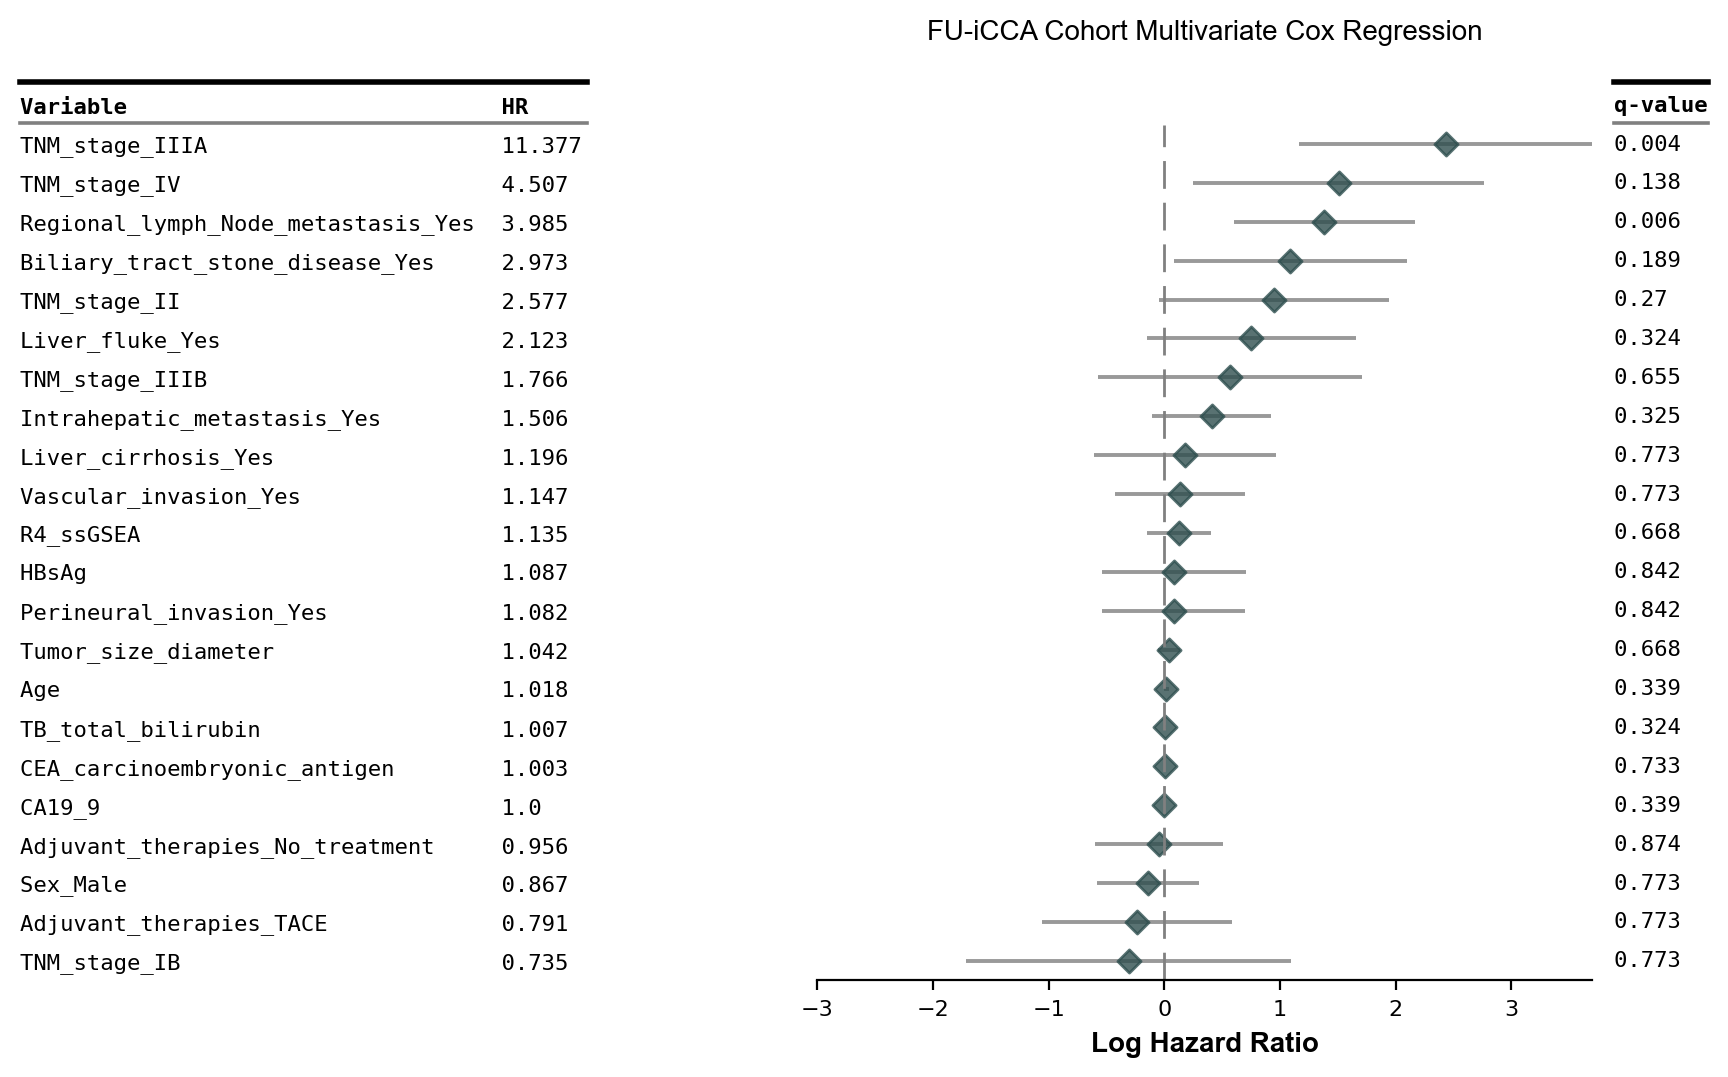

In [346]:
MyVisualization.forest_plot(coxph_mv_df, title='FU-iCCA Cohort Multivariate Cox Regression', figure_width=5, figure_height=6, tick_fontsize=8)

In [347]:
coxph_uni_df = MyRFunctions.coxph_multivariate(surv_df, all_clinical_feats_df[['R4_ssGSEA']])
coxph_uni_df

[1] "AIC of cox model:  931.077415567599"
[1] "Proportional Hazards Assumption: "
             chisq df          p
R4_ssGSEA 4.868048  1 0.02735843
GLOBAL    4.868048  1 0.02735843


,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,R4_ssGSEA,0.431023,1.538831,0.118577,3.634952,0.000278,1.219713,1.941441,0.198616,0.663431,0.000278


In [348]:
MyLib.save_csv(coxph_mv_df, 'FU_iCCA_cox_mutlivariate_R4_ssGSEA.csv', index=False)


File  patients_analysis/output_files_patients/FU_iCCA_cox_mutlivariate_R4_ssGSEA.csv saved, shape: (22, 11)


## CSGALNACT1

In [349]:
df = exp_df.T[['CSGALNACT1']].copy()
df['Group'] = (FU_iCCA_mut_df['BAP1_MT'] | FU_iCCA_mut_df['FGFR2_MT']).astype(int)
df['Group'] = df['Group'].replace({0: 'WT', 1: 'BAP1/FGFR2'})
df.head(10)

Sample ID Gene,CSGALNACT1,Group
111,4.519,WT
113,5.215,BAP1/FGFR2
115,3.504,WT
117,6.305,WT
121,3.206,WT
123,4.915,WT
125,4.357,BAP1/FGFR2
127,4.225,WT
131,4.135,WT
133,4.118,WT


ranksum p-value=6.506983941510711e-06
There is a significant association.


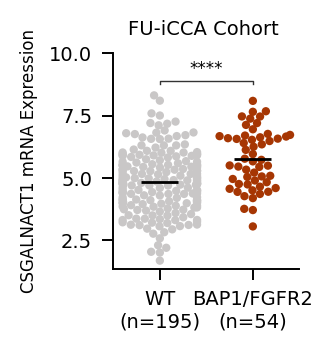

In [350]:
color = {'WT':'#c9c7c7', 'BAP1/FGFR2': '#a63603'}
x = 'Group'
gene = 'CSGALNACT1'
title = 'FU-iCCA Cohort'
Utils.compare_visualize_cat_features(df, x=x, y=gene, color_dic=color, y_label=f'{gene} mRNA Expression', test='ranksum', title=title, title_height=1., title_fontsize=7, figure_width=1.2, figure_height=1.4, label_fontsize=6, label_newline=True, ylim_top=10, ytick_step=2.5,save_figure=True)

## TP63

In [351]:
C6_features = ['FAT2', 'CASP1', 'IRF6', 'KRT15', 'SERPINB13']

In [352]:
ssgsea_df = MyRFunctions.ssgsea(exp_df, C6_features)

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [353]:
fu_icca_C6_ssgsea_df = zscore(ssgsea_df)
fu_icca_C6_ssgsea_df

,ssGSEA
111,-1.457838
113,0.361507
115,-0.146662
117,-1.125057
121,-0.772487
...,...
981,-0.027887
983,-0.765307
987,-0.592573
993,-0.377101


In [354]:
df = pd.concat([fu_icca_C6_ssgsea_df, exp_df.T[['TP63']]], axis=1)
df

,ssGSEA,TP63
111,-1.457838,0.690
113,0.361507,0.366
115,-0.146662,0.886
117,-1.125057,0.173
121,-0.772487,0.384
...,...,...
981,-0.027887,1.946
983,-0.765307,0.395
987,-0.592573,1.810
993,-0.377101,0.812


In [355]:
# MyLib.save_csv(df, 'FU_iCCA_TP63_5genes.csv')

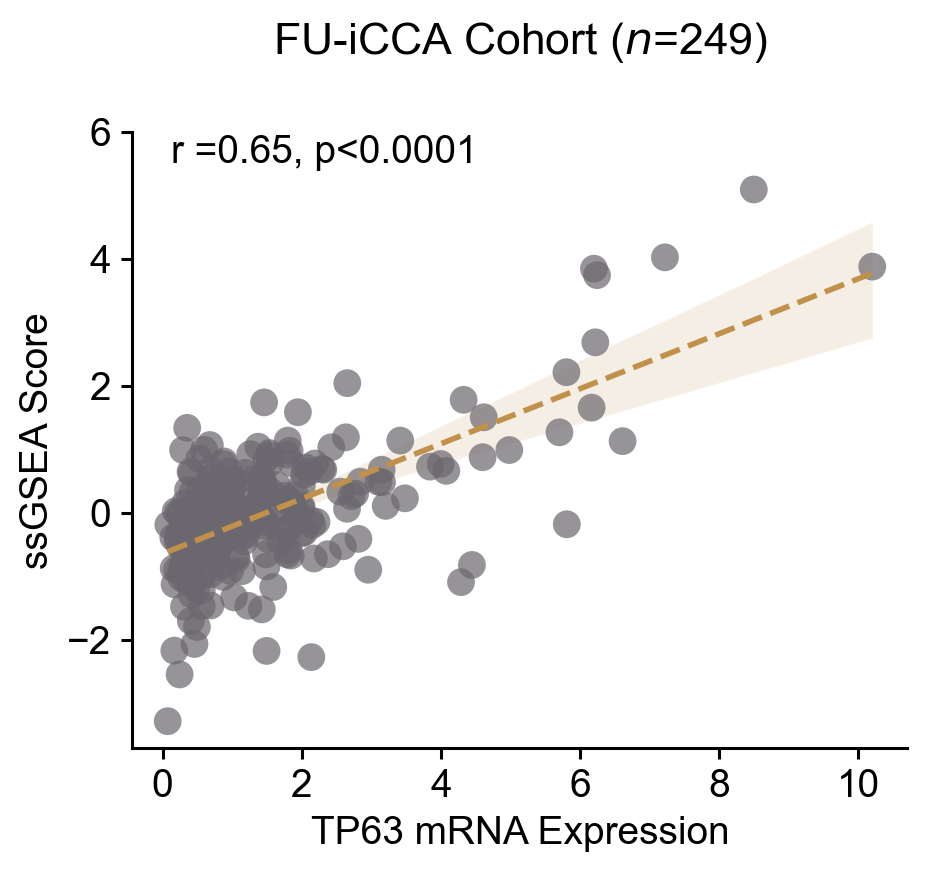

In [356]:
x = 'TP63'
y = 'ssGSEA'
points_color = '#6b676e'
line_color = '#C1914B'

MyVisualization.reg_plot(data_df=df, x_col=x, y_col=y, title=f'FU-iCCA Cohort ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, ylabel='ssGSEA Score',  xlabel=f"{x} mRNA Expression" , marker='o', title_height=1.1, ylim_top=6,  text_height=.95, ytick_step=2, file_name=f'FU_iCCA_{x}_{y}')

### Patient Stratification

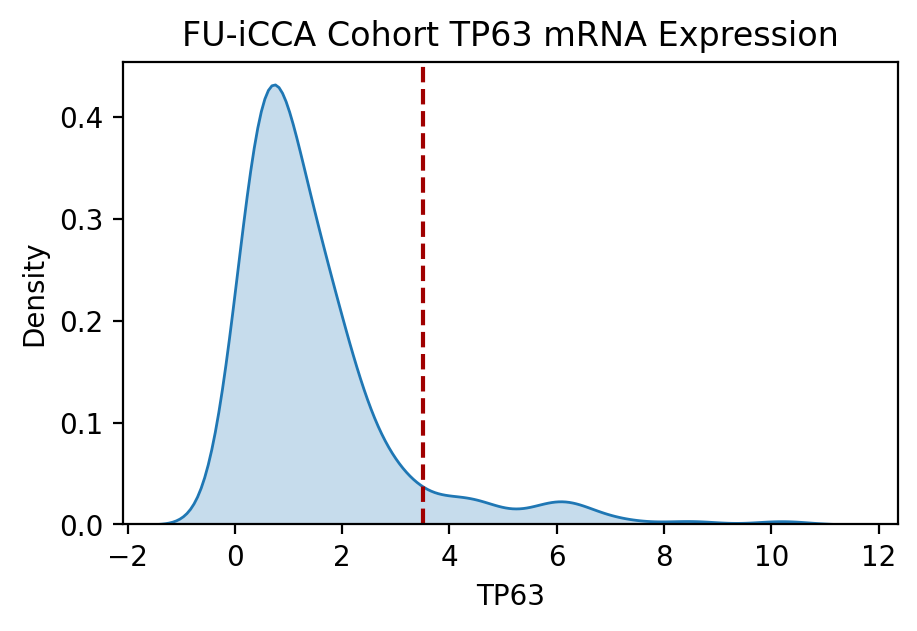

In [357]:
tp63_df = exp_df.T[['TP63']].copy()
MyVisualization.plot_distribution(tp63_df['TP63'], title='FU-iCCA Cohort TP63 mRNA Expression', x_vline=3.5)

In [358]:
tp63_thr= 3.5 # distribution tail
top_tp63_df = tp63_df[tp63_df['TP63']>tp63_thr][['TP63']]
top_tp63_df.shape

(20, 1)

In [359]:
percentage = (top_tp63_df.shape[0] / tp63_df.shape[0]) * 100
print('Percentage of patients with high expression of TP63:', round(percentage, 2))

Percentage of patients with high expression of TP63: 8.03


In [360]:
tp63_df['TP63_High'] = (tp63_df['TP63'] > tp63_thr).astype(int)
tp63_df

Sample ID Gene,TP63,TP63_High
111,0.690,0
113,0.366,0
115,0.886,0
117,0.173,0
121,0.384,0
...,...,...
981,1.946,0
983,0.395,0
987,1.810,0
993,0.812,0


### Save TP63 Results

In [361]:
tp63_all_df = pd.concat([tp63_df['TP63_High'], df['ssGSEA']], axis=1)
tp63_all_df

,TP63_High,ssGSEA
111,0,-1.457838
113,0,0.361507
115,0,-0.146662
117,0,-1.125057
121,0,-0.772487
...,...,...
981,0,-0.027887
983,0,-0.765307
987,0,-0.592573
993,0,-0.377101


In [362]:
MyLib.save_csv(tp63_all_df, f'FU-iCCA_TP63_mRNA_status_ssGSEA.csv')


File  patients_analysis/output_files_patients/FU-iCCA_TP63_mRNA_status_ssGSEA.csv saved, shape: (249, 2)


### TP63 Survival Analysis

In [363]:
surv_df = info_df[['OS, overall survival (day)', 'OS_event']].dropna(axis=0, how='all').astype(float)
surv_df['Group'] = 0  #'Low ssGSEA'
surv_df.loc[tp63_df.loc[surv_df.index, 'TP63_High'] == 1, 'Group'] = 1  #'High ssGSEA'
surv_df

,"OS, overall survival (day)",OS_event,Group
Patient_ID,,,
111,682.0,1.0,0
113,183.0,1.0,0
115,1806.0,0.0,0
117,808.0,1.0,0
121,1317.0,0.0,0
...,...,...,...
981,447.0,0.0,0
983,330.0,0.0,0
987,427.0,0.0,0


In [364]:
surv_df[surv_df['Group'] == 1].shape

(17, 3)

#### Kaplan-Meier

In [365]:
colors_l = ['#a00000','#077f97']
labels = ['Low', ' High']
MyRFunctions.survival_analysis(surv_df[['OS, overall survival (day)', 'OS_event']], surv_df[['Group']], group='Group', cur_title=f'FU-iCCA Cohort Overal Survival (TP63 mRNA Expression)', legend_lbls=labels, colors_elms=colors_l, plot_path=os.path.join(io_library.output_dir,f'FU-iCCA_Overal_Survival_TP63_Plot_{cluster}.pdf'))

0 221
1 17
------


#### Cox Regression

In [366]:
all_clinical_feats_df = pd.concat([tp63_df.loc[info_filtered_df.index, ['TP63']], info_filtered_df[cont_feats_cols], cat_clinical_feats_df], axis=1)
all_clinical_feats_df = all_clinical_feats_df.rename(columns={'TP63': 'TP63_mRNA'})
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace('-', '_') for col in all_clinical_feats_df.columns})# R cannot take -
all_clinical_feats_df = all_clinical_feats_df.rename(columns={col: col.replace(' ', '_') for col in all_clinical_feats_df.columns})# R cannot take space
all_clinical_feats_df = all_clinical_feats_df.astype(float)
all_clinical_feats_df.shape

(238, 22)

In [367]:
MyRFunctions.find_collinearity(all_clinical_feats_df.drop(['HBsAg'], axis=1), all_clinical_feats_df[['HBsAg']])

Model :
HBsAg ~ TP63_mRNA + Age + Tumor_size_diameter + TB_total_bilirubin + 
    CA19_9 + CEA_carcinoembryonic_antigen + Sex_Male + Intrahepatic_metastasis_Yes + 
    Liver_fluke_Yes + Biliary_tract_stone_disease_Yes + Vascular_invasion_Yes + 
    Liver_cirrhosis_Yes + Regional_lymph_Node_metastasis_Yes + 
    Perineural_invasion_Yes + TNM_stage_IB + TNM_stage_II + TNM_stage_IIIA + 
    TNM_stage_IIIB + TNM_stage_IV + Adjuvant_therapies_No_treatment + 
    Adjuvant_therapies_TACE



In [368]:
coxph_mv_df = MyRFunctions.coxph_multivariate(surv_df[['OS, overall survival (day)', 'OS_event']], all_clinical_feats_df)
coxph_mv_df

[1] "AIC of cox model:  881.746760468878"
[1] "Proportional Hazards Assumption: "
                                          chisq df          p
TP63_mRNA                           0.346079099  1 0.55634109
HBsAg                               0.117860014  1 0.73136717
Age                                 2.113187372  1 0.14603487
Tumor_size_diameter                 3.453393913  1 0.06312203
TB_total_bilirubin                  0.031149661  1 0.85990691
CA19_9                              0.030964968  1 0.86031857
CEA_carcinoembryonic_antigen        0.001522107  1 0.96887908
Sex_Male                            0.002082808  1 0.96359895
Intrahepatic_metastasis_Yes         0.934116940  1 0.33379542
Liver_fluke_Yes                     1.918445201  1 0.16602816
Biliary_tract_stone_disease_Yes     2.947807194  1 0.08599417
Vascular_invasion_Yes               0.303956079  1 0.58141288
Liver_cirrhosis_Yes                 0.758069211  1 0.38393343
Regional_lymph_Node_metastasis_Yes  3.203071632  1

,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,TNM_stage_IIIA,2.344029,10.423144,0.641167,3.655877,0.000256,2.966444,36.623617,1.087364,3.600693,0.002878
1,Regional_lymph_Node_metastasis_Yes,1.469309,4.346232,0.402482,3.650623,0.000262,1.974785,9.565463,0.680460,2.258159,0.002878
2,TP63_mRNA,0.135589,1.145212,0.075,1.807859,0.070628,0.988657,1.326557,-0.011408,0.282587,0.172647
3,TNM_stage_IV,1.360434,3.897884,0.635586,2.140441,0.032319,1.121547,13.546912,0.114709,2.606159,0.172647
4,Liver_fluke_Yes,0.869616,2.385995,0.458031,1.898597,0.057617,0.972283,5.855262,-0.028108,1.767341,0.172647
5,Intrahepatic_metastasis_Yes,0.495634,1.641539,0.26843,1.84642,0.064831,0.969981,2.778044,-0.030479,1.021747,0.172647
6,Biliary_tract_stone_disease_Yes,1.010482,2.746925,0.529632,1.907895,0.056405,0.972799,7.756582,-0.027578,2.048542,0.172647
7,CA19_9,0.000092,1.000092,0.00005,1.84879,0.064488,0.999994,1.00019,-0.000006,0.000190,0.172647
8,TB_total_bilirubin,0.008212,1.008246,0.004302,1.908878,0.056278,0.99978,1.016783,-0.000220,0.016644,0.172647
9,TNM_stage_II,0.802525,2.231168,0.506269,1.585176,0.112926,0.827171,6.018237,-0.189744,1.794794,0.248438


<Figure size 500x600 with 0 Axes>

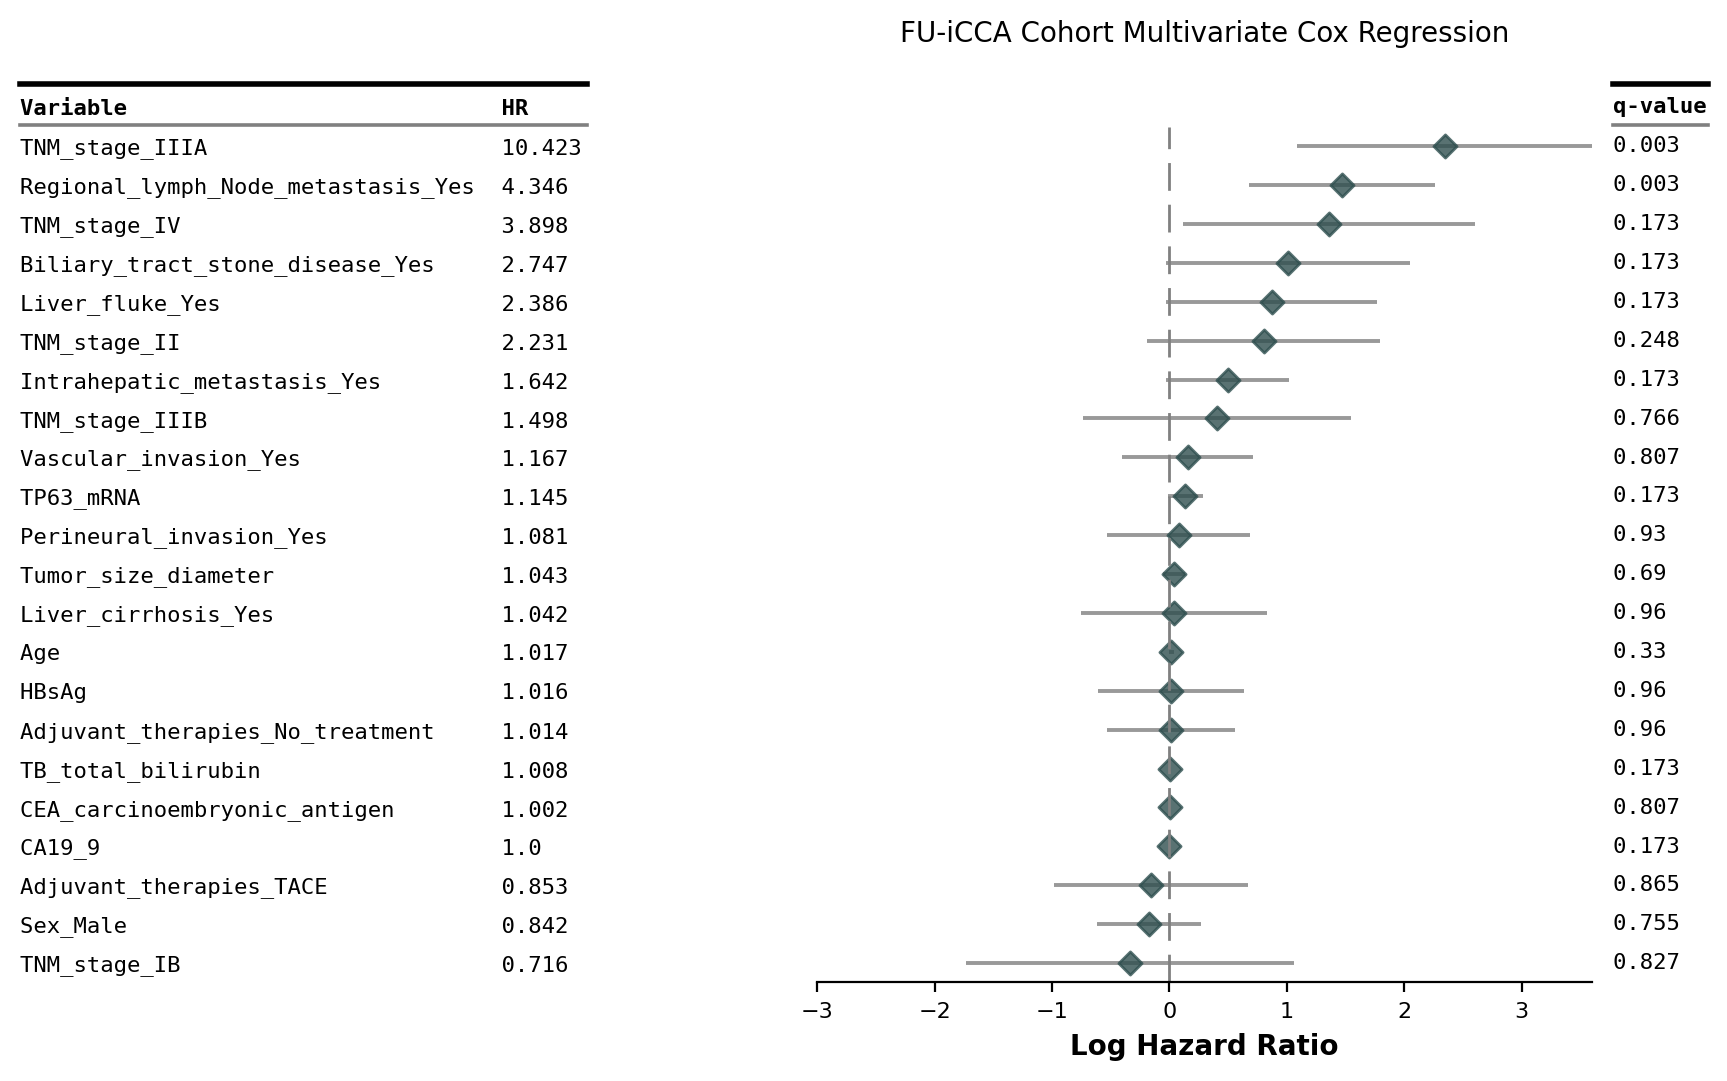

In [369]:
MyVisualization.forest_plot(coxph_mv_df, title='FU-iCCA Cohort Multivariate Cox Regression', figure_width=5, figure_height=6, tick_fontsize=8)

In [370]:
coxph_uni_df = MyRFunctions.coxph_multivariate(surv_df[['OS, overall survival (day)', 'OS_event']], all_clinical_feats_df[['TP63_mRNA']])
coxph_uni_df

[1] "AIC of cox model:  936.682123860388"
[1] "Proportional Hazards Assumption: "
              chisq df         p
TP63_mRNA 0.3570009  1 0.5501766
GLOBAL    0.3570009  1 0.5501766


,Variable,coef,exp(coef),se(coef),z,Pr(>|z|),lower .95,upper .95,log_lower .95,log_upper .95,q-value
0,TP63_mRNA,0.191522,1.211092,0.061055,3.136865,0.001708,1.074501,1.365046,0.071856,0.311188,0.001708


In [371]:
MyLib.save_csv(coxph_mv_df, 'FU_iCCA_cox_mutlivariate_TP63_ssGSEA.csv', index=False)


File  patients_analysis/output_files_patients/FU_iCCA_cox_mutlivariate_TP63_ssGSEA.csv saved, shape: (22, 11)


## Save results

In [372]:
FU_iCCA_R3_ssgsea_df

,ssGSEA,High_ssGSEA,R3_ssGSEA
111,-1.319180,Rest,0
113,0.039561,Rest,0
115,-0.630997,Rest,0
117,0.603531,Rest,0
121,0.848034,R3 Enriched,1
...,...,...,...
981,0.353042,Rest,0
983,0.784060,Rest,0
987,0.104952,Rest,0
993,0.879380,R3 Enriched,1


In [373]:
FU_iCCA_R4_ssgsea_df

,ssGSEA,High_ssGSEA,R4_ssGSEA
111,-1.516126,Rest,0
113,0.796358,R4 Enriched,1
115,0.265844,Rest,0
117,-1.586506,Rest,0
121,0.370129,Rest,0
...,...,...,...
981,-0.437273,Rest,0
983,0.199961,Rest,0
987,-1.213917,Rest,0
993,0.206530,Rest,0


In [374]:
d1 = FU_iCCA_R3_ssgsea_df[['ssGSEA', 'High_ssGSEA']]
d1 = d1.rename(columns={'ssGSEA':'R3_ssGSEA', 'High_ssGSEA':f'R3_status (thr={round(R3_threshold,3)})'})
d2 = FU_iCCA_R4_ssgsea_df[['ssGSEA', 'High_ssGSEA']]
d2 = d2.rename(columns={'ssGSEA':'R4_ssGSEA', 'High_ssGSEA':f'R4_status (thr={round(R4_threshold,3)})'})
df = pd.concat([d1, d2, FU_iCCA_mut_df[['mutation_R3', 'mutation_R4']]], axis=1)
MyLib.save_csv(df, 'FU_iCCA_ssGSEA_mutations.csv')
# df = pd.concat([d1, d2, FU_iCCA_mut_df, exp_df.T], axis=1)
# MyLib.save_csv(df, 'FU_iCCA_ssGSEA_mutations_RNA.csv')


File  patients_analysis/output_files_patients/FU_iCCA_ssGSEA_mutations.csv saved, shape: (249, 6)
